<b>Data mining Project - 2020/21</b><br/>
<span>
<b>Authors:</b> <a href="#">Diletta Goglia</a> and <a href="#">Marco Petix</a><br/>
<b>Python version:</b>  3.x<br/>
<b>Last update:</b> 26/10/2020
</span>

# Task 2: Data Clustering

## Introduction and Dataset Description

This notebook contains a clustering analysis on the "customers" dataset. 
Said dataset has been derived from the dataset "customer_supermarket" by gathering the informations regarding each individual customer and computing new indicators of its shopping behaviour.

The "customers" dataset is initially presented as split into two different dataframe: "customers_num", dedicated to the numerical attributes involved with the clustering process, and "customers_cat", dedicated to some additional attributes, both categorical and numeric, involved in the characterization of the clusters.

The whole dataset contains 3494 observations, each one describing the behaviour of a single customer.

**Importing libraries**

In [1]:
%matplotlib inline
import math

import numpy as np
import pandas as pd

import scipy.stats as stats
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

import collections
from collections import defaultdict


**Loading the dataset**

We read the .csv files containing the two sub-datasets.

In [2]:
cs = pd.read_csv('dataset/customers_num.csv', index_col=0)
cs_cat =  pd.read_csv('dataset/customers_cat.csv', index_col=0)

## Pre-Clustering operations

Before starting the clustering process we delve into some useful pre-processing tasks.

### Elimination of highly correlated features

We begin by examining the correlations between the attributes of the dataset to be clustered in order to identify the highly correlated couples. 
Dropping redundant attributes benefits the analysis by reducing the dimensionality of the dataset and rising the influence that more useful feature could have on the whole clustering process.  

With such aim in mind, we fix a maximum **threshold** value in order to identify highly correlated features and subsequently drop them.

In [3]:
corr_threshold = 0.9
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(cs.columns)):
    for j in range(i+1, len(cs.columns)):
        corr = cs[cs.columns[i]].corr(cs[cs.columns[j]])
        if  corr > corr_threshold:
            print(cs.columns[i] + "\t" + cs.columns[j] + "\t" + str(corr))

Att. A	Att. B	Corr(A,B)
I	Stot	0.9199487521505526
Iu	NSess	0.975362967042122
Eb	Ew	0.9181576651389154
Eb	Em	0.9606765468475107
Ew	Em	0.9049904909548746


As a result of this analysis, we decide to drop: *Eb, Em, Ew* and *Nsess*. 
The similar nature of the three entropy based attributes makes them provide very akin informations. Moreover, additional tests, not included in this notebook, confirmed their very low influence of the clustering process.

Despite the high correlation between the * Stot * and * I * attributes we decide not to eliminate either of them due to their relevance within the whole grouping process. This choice was suggested by the tests mentioned above and will be confirmed in the rest of the notebook.

In [4]:
cs_corr_columns = ['NSess', "Eb", "Ew", 'Em']
cs_no_out = cs.drop(cs_corr_columns, axis=1)
cs_no_out

I  Iu  Imax         E     Stot    Smax
CustomerID                                          
17809.0     305  27   204  4.754888   729.45  560.40
16098.0     435  24   112  4.305245  1107.51  293.14
18074.0      52   8    52  3.000000   185.30  185.30
17420.0     256  23   112  4.483856   485.08  215.76
16250.0     206  21   106  4.349649   373.54  210.24
...         ...  ..   ...       ...      ...     ...
14520.0      12   1    12  0.000000    10.20   10.20
13436.0      69   8    69  3.000000   113.54  113.54
15520.0     194  17   194  4.087463   320.70  320.70
14569.0      29   7    29  2.725481    80.09   80.09
12713.0     499  36   499  5.169925   722.85  722.85

[3477 rows x 6 columns]

### Normalization
The most common adopted normalizations are: Z-Score and Min-Max.
- The Z-Score normalization approach exploits the mean and standard deviation of data, and tries to center data wrt these two statistical properties.
- The Min-Max normalization approach instead allows to have data that are alwayse interpretable, so that we can avoid to apply inverse transformation.

In the coming analysis we choose to use the Min-Max normalization in order to have a leaner approach and avoid an unnecessary inverse transformation.

The code for the Z-score Normalization is still provided as an example.

#### Min-Max Normalization

In [5]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
cs_norm_minmax = minmax_scaler.fit_transform(cs_no_out.values)

#### Extra: Z-Score Normalization

In [6]:
# from sklearn.preprocessing import StandardScaler
# z_scaler = StandardScaler()
# cs_norm_z = z_scaler.fit_transform(cs_no_out.values)

# Clustering Analysis by K-means

## Identification of the best value of k 
The value of *k* is the main parameter of the algorithm and represents the number of clusters that we want to split the dataset into. There are several techniques to identify the optimal value of said parameter. Our aim in this context is to run multiple executions of the algorithm, each with a different value for *k*, and then performing an evaluation analysis.

We start from an initial value of 2 and we keep computing the clusterization until we reach the value of 20, our choice for the maximum value of *k*. 
<br>As already mentioned, these values act as the fisrt parameter, **n_clusters**, for the K-means algorithm. 
<br>The second parameter, **n_init**, is kept at its default value of 10. This means that, for each value of k, K-means will try ten different sets of randomly picked initial centroids. 
<br>Finally, the third parameter **max_iter**, which is the maximum number of iterations of the algorithm for a single run, is set to 100 (default value: 300).

The Inertia (Sum of Squared Errors) and the Silhouette scores are computed and stored for each run. Both of them are utilized within the evaluation process described in the following subsections.

In [7]:
from sklearn.cluster import KMeans # we import the Sklearn implementation of the algorithm
from sklearn.metrics import silhouette_score 

max_k = 20
sse= []
silhouette = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100) # Initializing K-means parameters
    kmeans.fit(cs_norm_minmax) # performing K-means clustering
    
    sse.append(kmeans.inertia_) # storing the distorsion values
    silhouette.append(silhouette_score(cs_norm_minmax, kmeans.labels_)) # storing the silhouette scores

### Elbow Method on the clusters Inertia
In cluster analysis, the elbow method is a heuristic used in determining the number of clusters *k* in a data set. It consists of plotting the SSE as a function of the number of clusters, and **picking the elbow** of the curve as the number of clusters to use.

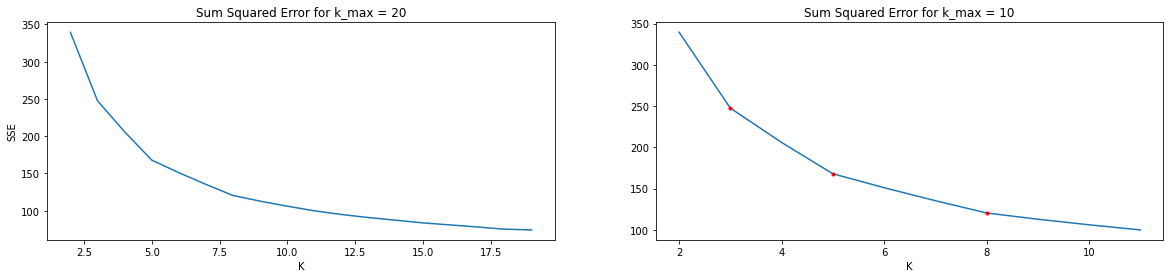

In [8]:
# print the elbow plots
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
visual_max_k = [20, 10]
for i in range(2):
    axs[i].plot(range(2, len(sse[0:visual_max_k[i]]) + 2), list(sse[0:visual_max_k[i]]))
    axs[i].set_title('Sum Squared Error for k_max = ' + str(visual_max_k[i]))
    axs[i].set_xlabel('K')
axs[0].set_ylabel('SSE')

axs[1].plot([3], [sse[1]], marker='.', c='r')
axs[1].plot([5], [sse[3]], marker='.', c='r')
axs[1].plot([8], [sse[6]], marker='.', c='r')

plt.show()

The graphs above display how the inertia seems to behave less linearly between 3 and 8. This means that 3, 5 or 8 could be potential candidate for the optimal K.

### Average Silhouette Method

The silhouette score is a indicator of both separation and cohesion among clusters. Here we look for the clusterization with the maximum Silhouette score among those computed by K-means.

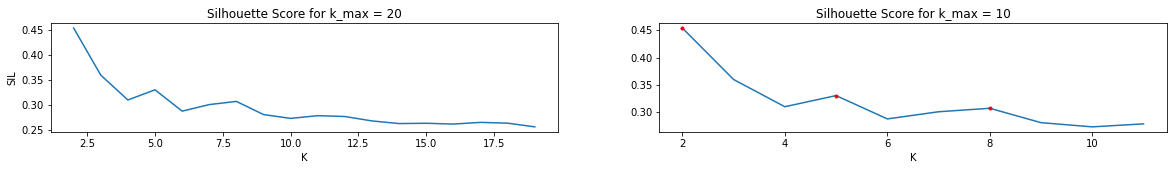

In [9]:
# Create two subplots and unpack the output array immediately
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,2))
visual_max_k = [20, 10]
for i in range(len(visual_max_k)):
    axs[i].plot(range(2, len(silhouette[0:visual_max_k[i]]) + 2), silhouette[0:visual_max_k[i]])
    axs[i].set_title('Silhouette Score for k_max = ' + str(visual_max_k[i]))
    axs[i].set_xlabel('K')
axs[0].set_ylabel('SIL')

axs[1].plot([2], [silhouette[0]], marker='.', c='r')
axs[1].plot([5], [silhouette[3]], marker='.', c='r')
axs[1].plot([8], [silhouette[6]], marker='.', c='r')

plt.show()

The Average Silhouette method suggest 2, the point with the maximum score, as the optimal value for the *k* parameter. Also, the scores for k equals to both 5 and 8 seems to representes small local maximas. Their study could therefore lead to interesting conclusions too.

### Insights from Hierarchical Clustering
Here we try to identify the optimal number of clusters by analysing the hierarchical clustering performed throught the Ward method. <br>Said method aims at the local optimization of the SSE fuction and therefore it is often used in conjunction with K-means.

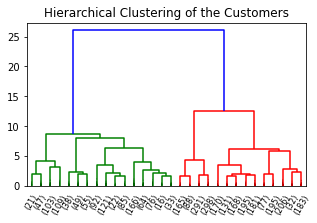

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(5, 3))
plt.title("Hierarchical Clustering of the Customers")
plt.axhline(y=80, ls='--', c='red')
dend = dendrogram(linkage(cs_norm_minmax, method='ward'), truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

The clustering obtained throught the Ward linkage seems to suggest the presence of two main clusters within the dataset.

### Comparing conclusions
We prepare a graph comparing the results from the Elbow Method and the analysis of the Silhouette scores.

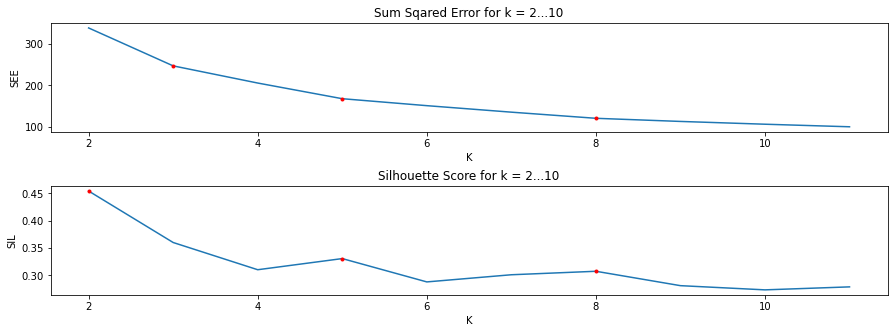

In [11]:
# Create two subplots and unpack the output array immediately
f, axs = plt.subplots(nrows=2, figsize=(15,5))
plt.subplots_adjust(hspace=0.5)
axs[0].plot(range(2, len(sse[0:10]) + 2), sse[0:10])
axs[0].set_title('Sum Sqared Error for k = 2...10')
axs[0].set_ylabel('SEE')
axs[1].set_xlabel('K')
axs[0].plot([3], [sse[1]], marker='.', c='r')
axs[0].plot([5], [sse[3]], marker='.', c='r')
axs[0].plot([8], [sse[6]], marker='.', c='r')

axs[1].plot(range(2, len(silhouette[0:10]) + 2), silhouette[0:10])
axs[1].set_title('Silhouette Score for k = 2...10')
axs[1].set_ylabel('SIL')
axs[0].set_xlabel('K')
axs[1].plot([2], [silhouette[0]], marker='.', c='r')
axs[1].plot([5], [silhouette[3]], marker='.', c='r')
axs[1].plot([8], [silhouette[6]], marker='.', c='r')

plt.show()

According to both methods the values 5 and 8 could be plausible candidates for the role of optimal *k*. 
Additionally, the elbow method suggests the value 3 and, the value 2 still stands as the most promising candidate according to its Silhouette score. 
The former is also supported by the dendrogram previously displayed.

Ultimately, we decide to compute four different clustering, each associated with a potential candidate, and to leave the choice for the best k to after an evaluation process on the results obtained.

In [12]:
Ks = [2, 3, 5, 8]

## Clustering by K-means for K = 2, 3, 5, 8

We perform the clustering for the four values of *k* previously picked.
<br>For each *k* we store the information regarding the centroids, the SSE values associated with the clustering and, most importantly, the labels associating each record to its cluster.

In [13]:
cs_centers = []
cs_labels = []
cs_inertia = []
for k in Ks:
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100) 
    kmeans.fit(cs_norm_minmax) # we perform the clusterin for each value of k
    cs_centers.append(minmax_scaler.inverse_transform(kmeans.cluster_centers_)) # we store the coordinates of the centroids
    cs_labels.append(kmeans.labels_) # we store the labels associated with the records
    cs_inertia.append(kmeans.inertia_) # we store the SSE value associated with the clustering

We then join the dataset containing the numerical attributes with the one containing the ones dedicated to the post-clustering analysis. 
<br>To the resulting dataframe we subsequently add the labels previously obtained as results from the several clustering.

In [14]:
cs_clusters = cs_no_out.join(cs_cat)
for i in range(len(Ks)):
    cs_clusters['C' + str(Ks[i])] = cs_labels[i]
cs_clusters

I  Iu  Imax         E     Stot    Smax         Country  Monday  \
CustomerID                                                                     
17809.0     305  27   204  4.754888   729.45  560.40  United Kingdom     0.0   
16098.0     435  24   112  4.305245  1107.51  293.14  United Kingdom     4.0   
18074.0      52   8    52  3.000000   185.30  185.30  United Kingdom     0.0   
17420.0     256  23   112  4.483856   485.08  215.76  United Kingdom     0.0   
16250.0     206  21   106  4.349649   373.54  210.24  United Kingdom     0.0   
...         ...  ..   ...       ...      ...     ...             ...     ...   
14520.0      12   1    12  0.000000    10.20   10.20  United Kingdom     0.0   
13436.0      69   8    69  3.000000   113.54  113.54  United Kingdom     0.0   
15520.0     194  17   194  4.087463   320.70  320.70  United Kingdom     0.0   
14569.0      29   7    29  2.725481    80.09   80.09  United Kingdom     0.0   
12713.0     499  36   499  5.169925   722.85  722.85         Germany    36.0   

            Tuesday  Wednesday  ...  September  October  November  December  \
CustomerID                      ...                                           
17809.0        13.0        3.0  ...        0.0      0.0       3.0       0.0   
16098.0        37.0        6.0  ...       13.0      0.0       0.0       0.0   
18074.0         8.0        0.0  ...        0.0      0.0       0.0       0.0   
17420.0        17.0        0.0  ...        0.0      8.0       0.0       0.0   
16250.0        13.0       10.0  ...        0.0      0.0       0.0       0.0   
...             ...        ...  ...        ...      ...       ...       ...   
14520.0         0.0        0.0  ...        0.0      0.0       0.0       0.0   
13436.0         0.0        0.0  ...        0.0      0.0       0.0       0.0   
15520.0         0.0        0.0  ...        0.0      0.0       0.0       0.0   
14569.0         0.0        0.0  ...        0.0      0.0       0.0       0.0   
12713.0         0.0        0.0  ...       36.0      0.0       0.0       0.0   

            Weekday      Month  C2  C3  C5  C8  
CustomerID                                      
17809.0     Tuesday   February   0   1   0   0  
16098.0     Tuesday  September   1   1   2   0  
18074.0     Tuesday    January   1   2   4   2  
17420.0     Tuesday       June   1   1   2   2  
16250.0     Tuesday    January   1   2   2   2  
...             ...        ...  ..  ..  ..  ..  
14520.0      Friday     August   1   2   4   5  
13436.0      Friday     August   1   2   4   5  
15520.0      Friday     August   1   1   2   0  
14569.0      Friday     August   1   2   4   5  
12713.0      Monday  September   0   0   0   6  

[3477 rows x 32 columns]

### Extra: Visualization aids
The code below consists in procedures and structures needed to build plots that will be useful to understand the distribution and the nature of the obtained clusters.

In [15]:
visual_labels = [[] for _ in range(len(Ks))]
for i in range(len(Ks)):
    for j in range(1,len(cs_centers[i]) + 1):
        visual_labels[i].append('Cluster ' + str(j))

In [16]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
visual_colors = []
for i in range(len(Ks)):
    visual_colors.append(colors[0:Ks[i]])

In [17]:
def autolabel(rects, i = None, j = None):
    if (i != None) and (j!=None): 
        target = axs[i][j]
    elif i != None:
        target = axs[i]
    else:
        target = axs    
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        target.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


## Characterization of the obtained clusters
We now begin an analysis aimed toward the study of the clusters composition and population, so that we can fully understand and interprete the results given by the k-means algorithm.
<br>The following graphs describe the current distribution of the original population of the customers dataset within the various clusters and according to the four different clustering:

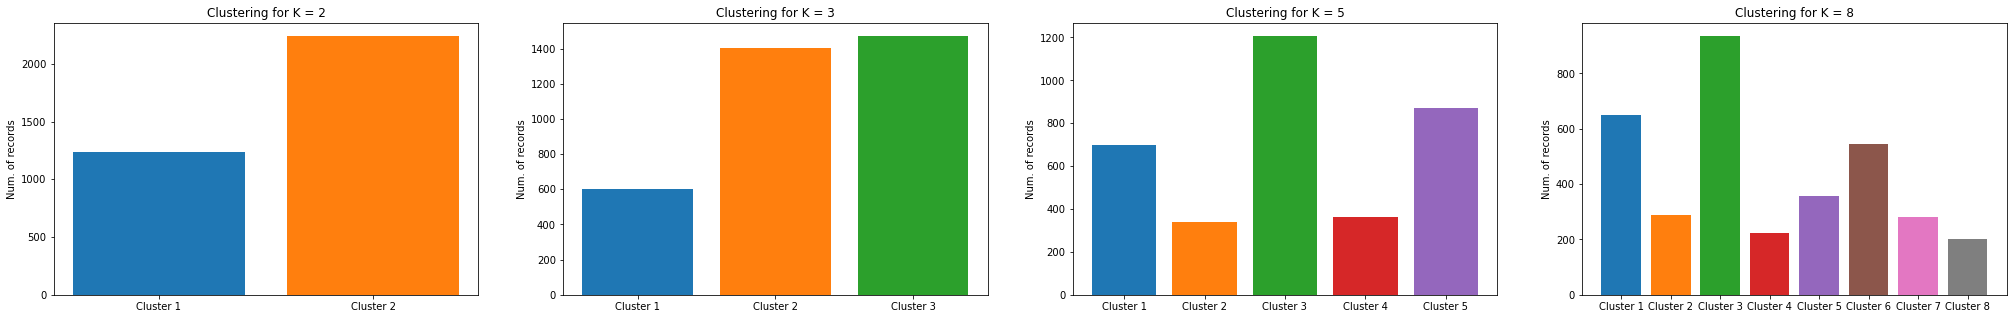

In [18]:
f, axs = plt.subplots(nrows=1, ncols=len(Ks), figsize=(35,5))
for i in range(len(Ks)):
    hist, bins = np.histogram(cs_labels[i], bins=range(0, len(set(cs_labels[i])) + 1))
    #axs[i].pie(hist, labels=visual_labels[i])
    axs[i].bar(list(range(0,len(set(cs_labels[i])))), hist, color=visual_colors[i], tick_label=visual_labels[i])
    axs[i].set_title('Clustering for K = ' + str(Ks[i]))
    axs[i].set_ylabel('Num. of records')

### Identifying the most influential attributes

In order to identify the attributes that contribute the most to the clustering process, we dedicate the current section to the study of the previously stored centroids.

The following graphs displays the differences in value for each of the dataset attributes among the centroid of each clusters. 

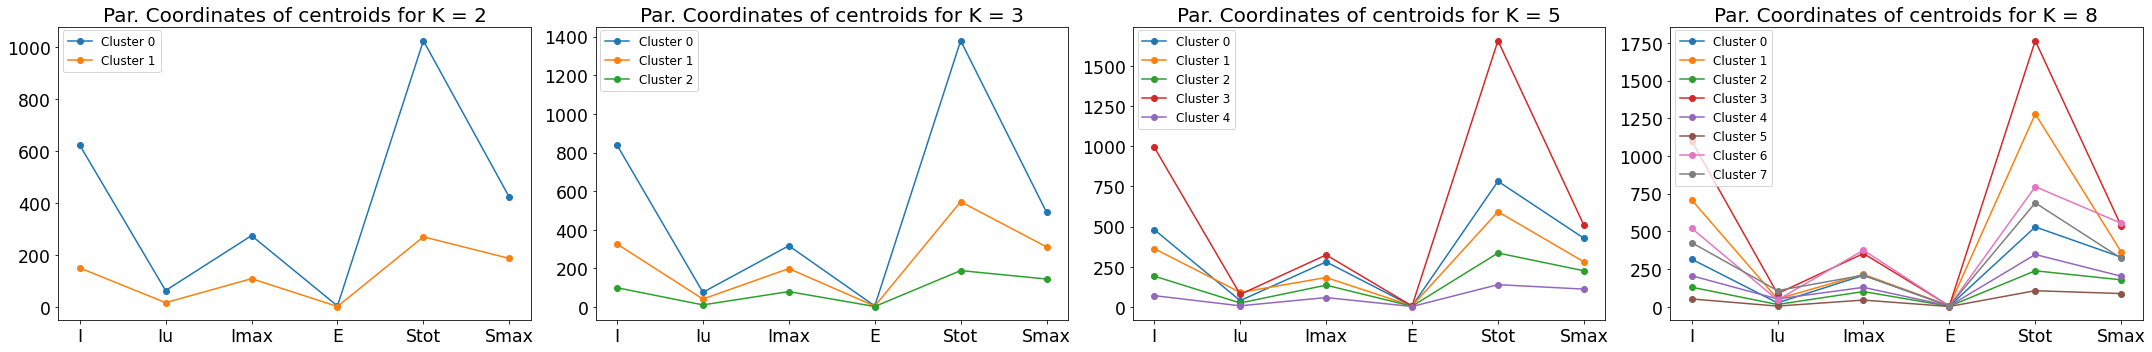

In [19]:
from math import pi
f, axs = plt.subplots(nrows=1, ncols=len(Ks), figsize=(30,5), sharex=True)
for i in range(len(Ks)):
    for j in range(0, len(cs_centers[i])):
        axs[i].plot(cs_centers[i][j], marker='o', label='Cluster %s' % j)
    axs[i].set_xticklabels(['0', 'I', 'Iu', 'Imax', 'E', 'Stot', 'Smax'])
    axs[i].tick_params(labelsize='xx-large')
    axs[i].legend(fontsize=12, bbox_to_anchor=(0.01, 0.99), loc='upper left', borderaxespad=0.)
    axs[i].set_title('Par. Coordinates of centroids for K = ' + str(Ks[i]), fontsize=20)
    plt.tight_layout()
plt.show()

The same results seem to be shared among the four clustering: the centroids, and thus the population of each cluster, mostly differs in their values for I and Stot. 
<br> The attributes Iu, Imax and Smax seem to have a slightly weaker influence and finally the attribute E seems almost irrelevant. <br>The latter consideration of E, however, may be unfairly encouraged by the difference in scale from the other attributes. 

To clarify these doubts, focusing additional analysis on individual attributes, or their subsets, is required.

C:\Users\Diletta\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


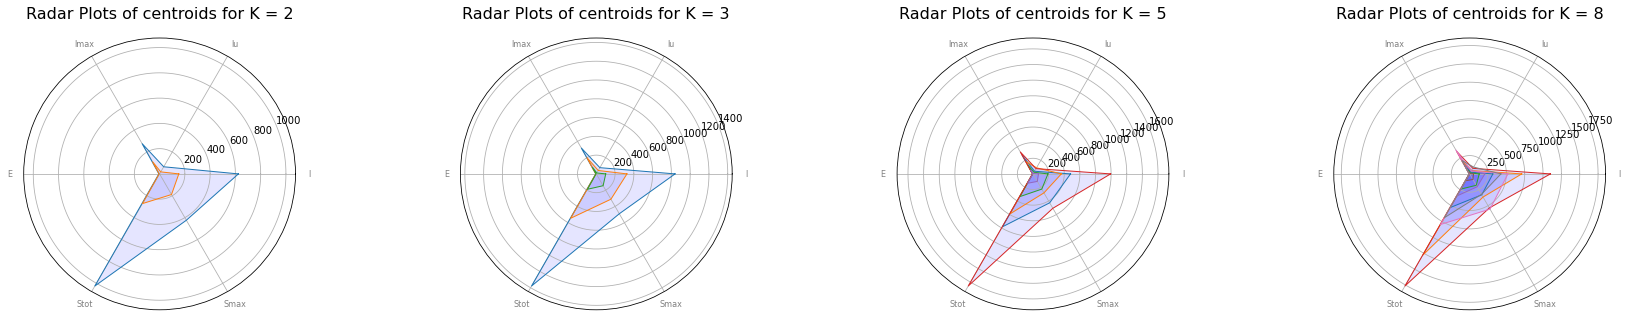

In [20]:
f, axs = plt.subplots(nrows=1, ncols=len(Ks), figsize=(30,5))
# number of variable
N = len(cs_no_out.columns)
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
for j in range(4):
    for i in range(0, len(cs_centers[j])):
        angles = [n / float(N) * 2 * pi for n in range(N)]
        values = cs_centers[j][i].tolist()
        values += values[:1]
        angles += angles[:1]
        # Initialise the spider plot
        axs[j] = plt.subplot(1,4,j+1,polar=True)
    # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], cs_no_out.columns, color='grey', size=8) 
    # Plot data
        axs[j].plot(angles, values, linewidth=1, linestyle='solid')
     # Fill area
        axs[j].fill(angles, values, 'b', alpha=0.1)
        axs[j].set_title('Radar Plots of centroids for K = ' + str(Ks[j]), fontsize=16)
    #plt.tight_layout()
plt.show()

### 

#### Comparing the average value of the numerical attributes 

The following graphs display the average value of the attributes from the customers dataset with respect to the various clusters and for each of the four clustering.

The attributes I, Imax, Stot and Smax are displayed together due to their mostly similar scale.
<br>For the opposite reason, the attributes Iu and E are displayed in their individual series of graphs.

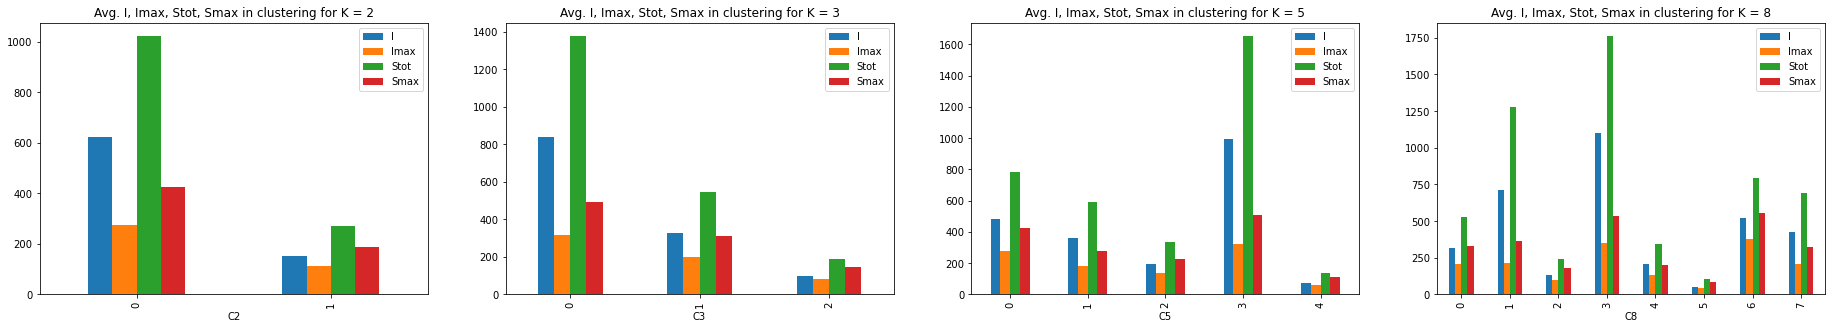

In [21]:
f, axs = plt.subplots(nrows=1, ncols=len(Ks), figsize=(32,30))
plt.subplots_adjust(hspace=0.5)

for i in range(len(Ks)):
    cluster_col = 'C' + str(Ks[i])
    cs_clusters.groupby(cluster_col)[['I', 'Imax', 'Stot', 'Smax']].mean().plot(kind='bar',figsize=(32, 5), ax=axs[i], title='Avg. I, Imax, Stot, Smax in clustering for K = ' + str(Ks[i])) 
plt.show()

The graphs above clearly display how the proportions among the four attributes are mostly maintained within the clusters of each clustering. The division of the customers in different groups seems solely guided by the customers' tendency to spend and to acquire products. The attributes here, I and Imax, don't provide information regarding the variety of products purchased but just their amount. 

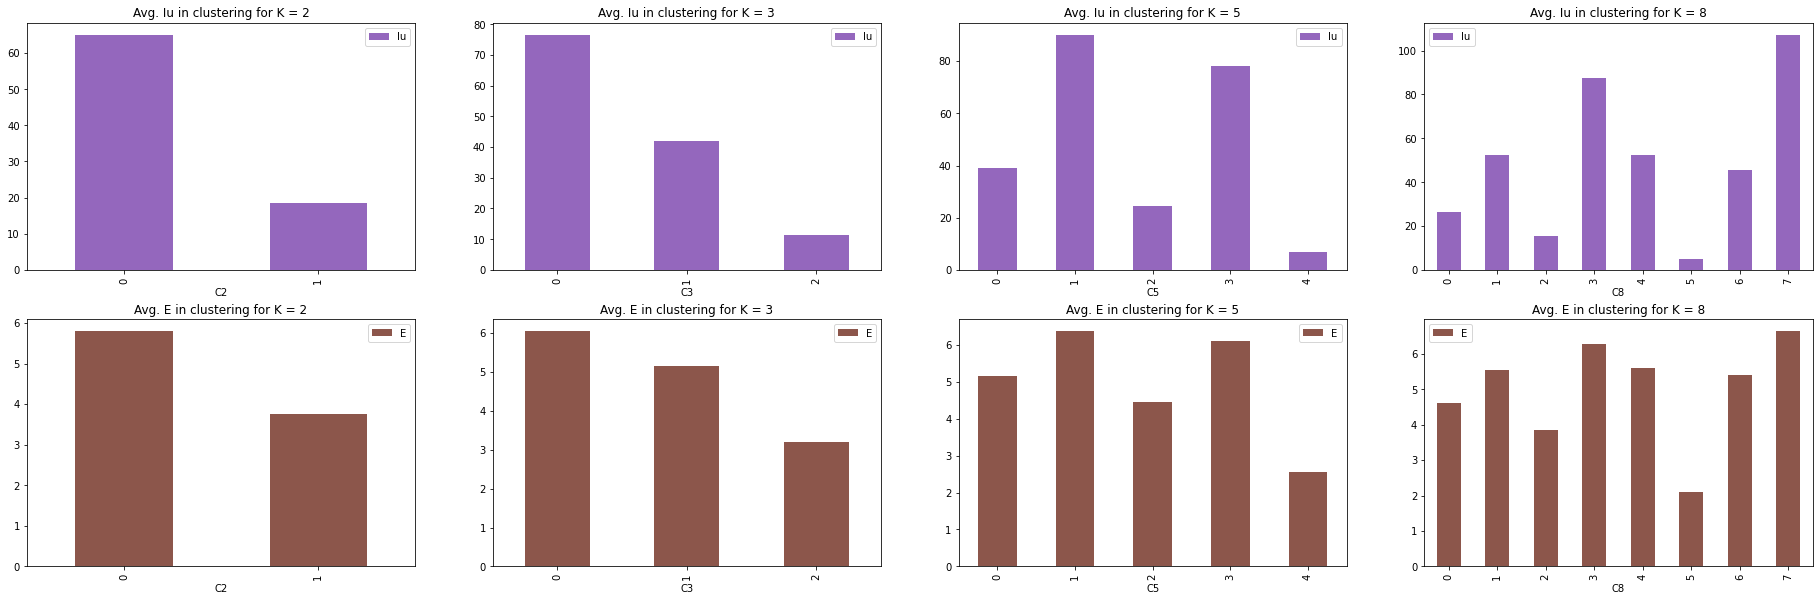

In [22]:
f, axs = plt.subplots(nrows=2, ncols=len(Ks), figsize=(32,10))
for i in range(len(Ks)):
    cluster_col = 'C' + str(Ks[i])
    cs_clusters.groupby(cluster_col)[['Iu']].mean().plot(kind='bar',figsize=(32, 10), color='tab:purple', ax=axs[0][i], title='Avg. Iu in clustering for K = ' + str(Ks[i]))
    cs_clusters.groupby(cluster_col)[['E']].mean().plot(kind='bar',figsize=(32, 10), color='tab:brown', ax=axs[1][i], title='Avg. E in clustering for K = ' + str(Ks[i]))
plt.show()

The graphs above present very similar distributions, this is due to the high correlation among the Iu and E attributes, acting both as measure of disorder and variety. 
<br>The graphs for k equals to 2 and 3 here display a behaviour very similar to the one assumed for the other attribtues. For those clustering, the customers are grouped by their spending power and variety in terms of type of products bought. 

Such behaviour however is slightly avoided by the clustering for k equals to 5 and 8. Unlike for k equals to 2 and 3, here we can twice see how the clusters with the greatest measures of variety (in terms of avg. Iu and E) are not the same ones containing the highest spenders. 

#### Characterizing the clusters through additional and categorical attributes

##### Categorical Attribute Country

Here we consider the *Country* attribute and we build plots in order to understand how clusters are distributed with respect to this lable. 

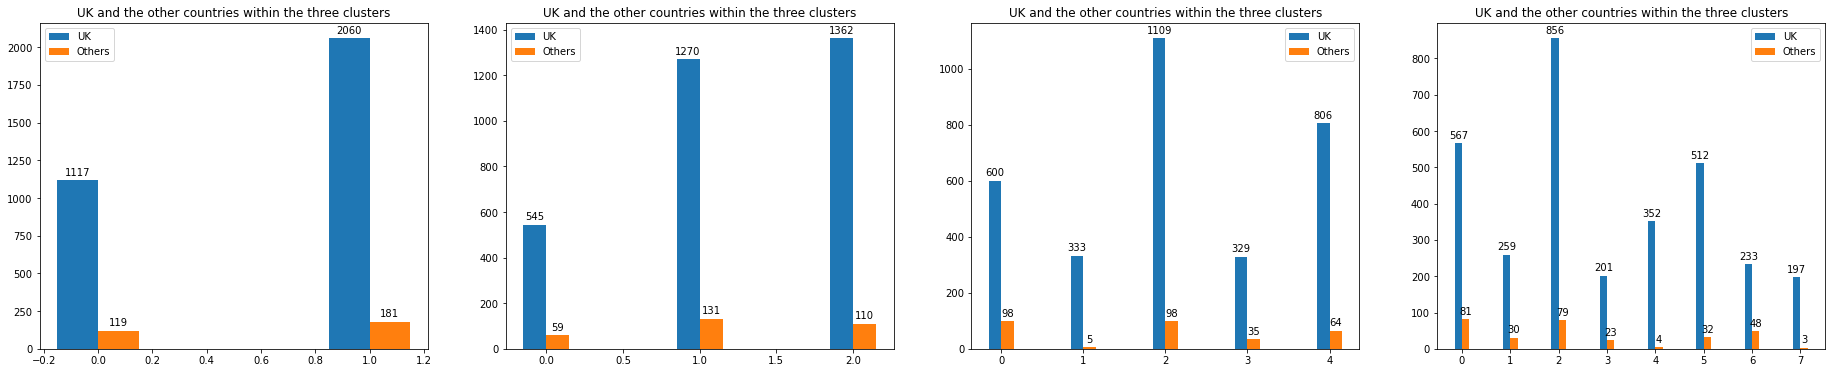

In [23]:
UK_bar = [[] for _ in range(len(Ks))]
UK_bar[0] = cs_clusters[cs_clusters.Country == 'United Kingdom'].groupby(['C2', 'Country']).size().unstack()
UK_bar[0]['Others'] = pd.DataFrame(cs_clusters[cs_clusters.Country != 'United Kingdom'].groupby(['C2']).size())
UK_bar[1] = cs_clusters[cs_clusters.Country == 'United Kingdom'].groupby(['C3', 'Country']).size().unstack()
UK_bar[1]['Others'] = pd.DataFrame(cs_clusters[cs_clusters.Country != 'United Kingdom'].groupby(['C3']).size())
UK_bar[2] = cs_clusters[cs_clusters.Country == 'United Kingdom'].groupby(['C5', 'Country']).size().unstack()
UK_bar[2]['Others'] = pd.DataFrame(cs_clusters[cs_clusters.Country != 'United Kingdom'].groupby(['C5']).size())
UK_bar[3] = cs_clusters[cs_clusters.Country == 'United Kingdom'].groupby(['C8', 'Country']).size().unstack()
UK_bar[3]['Others'] = pd.DataFrame(cs_clusters[cs_clusters.Country != 'United Kingdom'].groupby(['C8']).size())

width = 0.15

f, axs = plt.subplots(nrows=1, ncols=4, figsize=(32,6))
for i in range(len(Ks)):
    x = np.arange(len(visual_labels[i]))
    autolabel(axs[i].bar(x - width/2, UK_bar[i]['United Kingdom'], width, label='UK'), i)
    autolabel(axs[i].bar(x + width/2, UK_bar[i]['Others'], width, label='Others'), i)
    axs[i].legend()
    axs[i].set_title('UK and the other countries within the three clusters')

The vast predominancy of customers coming from the United Kingdom with respect to those from other countries was an expected result. Unfortunately, the plots don't seem to highlights any interesting behaviour from the customer associated with other countries. 

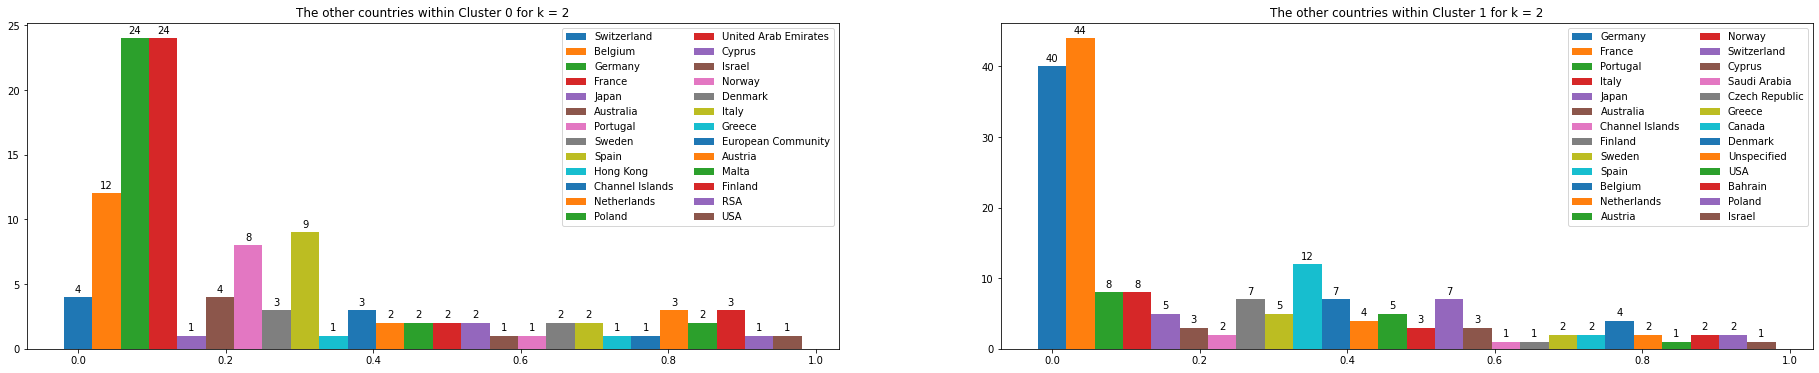

In [24]:
other_countries = [[] for _ in range(Ks[0])]
other_values = [[] for _ in range(Ks[0])]
#cs_clusters = cs_clusters.sort_values(by=['Country'])

for cluster in range(Ks[0]):
    for country in cs_clusters[(cs_clusters.Country != 'United Kingdom') & (cs_clusters.C2 == cluster)].Country.unique():
        other_countries[cluster].append(country)
        other_values[cluster].append(cs_clusters[(cs_clusters.C2 == cluster) & (cs_clusters.Country == country)].Country.count())

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(32,6))
x = np.arange(len(visual_labels[0]))
width = 0.15

for i in range(Ks[0]):
    for j in range(len(other_countries[i])):
        point = (1/len(other_countries[i])*j)
        autolabel(axs[i].bar( point, other_values[i][j], (1/len(other_countries[i])), label=other_countries[i][j]), i)
        axs[i].legend(ncol=2)
    axs[i].set_title('The other countries within Cluster '+ str(i) + ' for k = ' + str(Ks[0]))
plt.show()

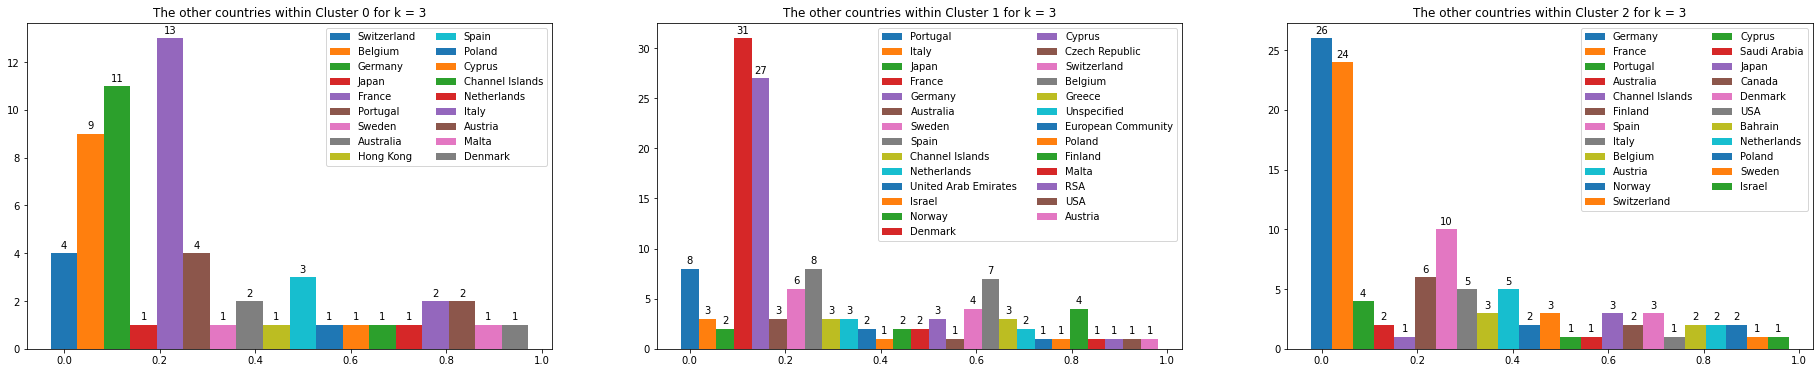

In [25]:
other_countries = [[] for _ in range(Ks[1])]
other_values = [[] for _ in range(Ks[1])]
#cs_clusters = cs_clusters.sort_values(by=['Country'])

for cluster in range(Ks[1]):
    for country in cs_clusters[(cs_clusters.Country != 'United Kingdom') & (cs_clusters.C3 == cluster)].Country.unique():
        other_countries[cluster].append(country)
        other_values[cluster].append(cs_clusters[(cs_clusters.C3 == cluster) & (cs_clusters.Country == country)].Country.count())

f, axs = plt.subplots(nrows=1, ncols=3, figsize=(32,6))
x = np.arange(len(visual_labels[1]))
width = 0.15

for i in range(Ks[1]):
    for j in range(len(other_countries[i])):
        point = (1/len(other_countries[i])*j)
        autolabel(axs[i].bar( point, other_values[i][j], (1/len(other_countries[i])), label=other_countries[i][j]), i)
        axs[i].legend(ncol=2)
    axs[i].set_title('The other countries within Cluster '+ str(i) + ' for k = ' + str(Ks[1]))
plt.show()

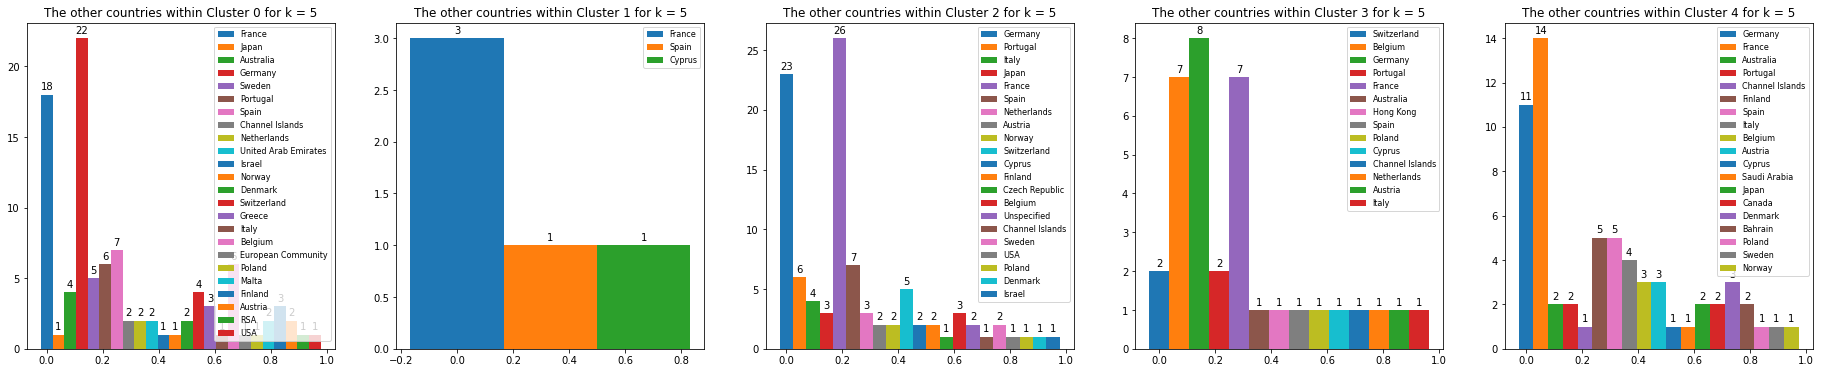

In [26]:
other_countries = [[] for _ in range(Ks[2])]
other_values = [[] for _ in range(Ks[2])]
#cs_clusters = cs_clusters.sort_values(by=['Country'])

for cluster in range(Ks[2]):
    for country in cs_clusters[(cs_clusters.Country != 'United Kingdom') & (cs_clusters.C5 == cluster)].Country.unique():
        other_countries[cluster].append(country)
        other_values[cluster].append(cs_clusters[(cs_clusters.C5 == cluster) & (cs_clusters.Country == country)].Country.count())

f, axs = plt.subplots(nrows=1, ncols=5, figsize=(32,6))
x = np.arange(len(visual_labels[2]))
width = 0.15

for i in range(Ks[2]):
    for j in range(len(other_countries[i])):
        point = (1/len(other_countries[i])*j)
        autolabel(axs[i].bar( point, other_values[i][j], (1/len(other_countries[i])), label=other_countries[i][j]), i)
        axs[i].legend(ncol=1, fontsize=8)
    axs[i].set_title('The other countries within Cluster '+ str(i) + ' for k = ' + str(Ks[2]))
plt.show()

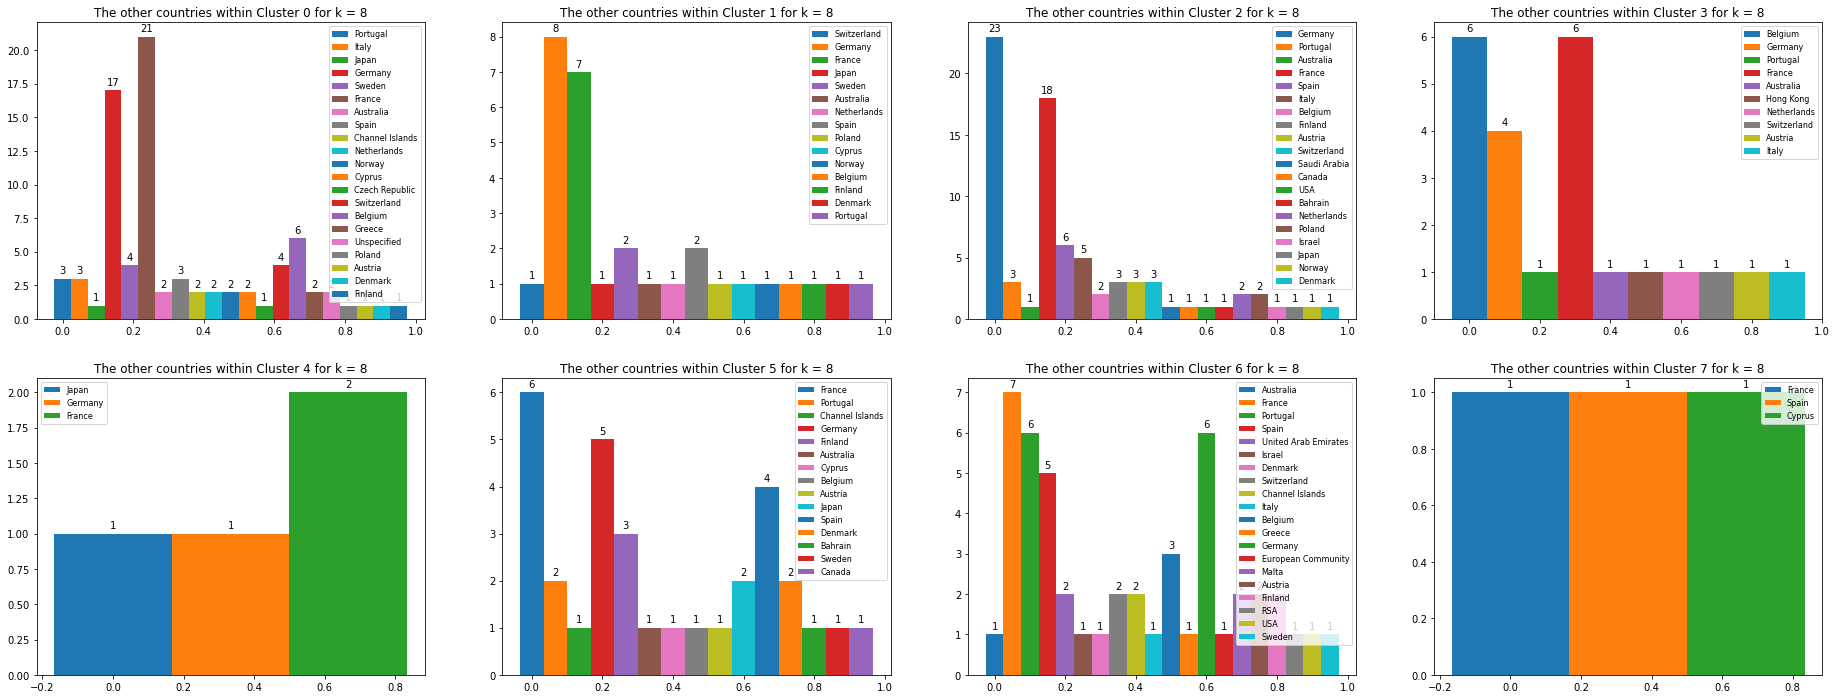

In [27]:
other_countries = [[] for _ in range(Ks[3])]
other_values = [[] for _ in range(Ks[3])]
#cs_clusters = cs_clusters.sort_values(by=['Country'])

for cluster in range(Ks[3]):
    for country in cs_clusters[(cs_clusters.Country != 'United Kingdom') & (cs_clusters.C8 == cluster)].Country.unique():
        other_countries[cluster].append(country)
        other_values[cluster].append(cs_clusters[(cs_clusters.C8 == cluster) & (cs_clusters.Country == country)].Country.count())

f, axs = plt.subplots(nrows=2, ncols=4, figsize=(32,12))
x = np.arange(len(visual_labels[3]))
width = 0.15

for i in range(Ks[3]):
    for j in range(len(other_countries[i])):
        point = (1/len(other_countries[i])*j)
        autolabel(axs[int(i/4)][i%4].bar( point, other_values[i][j], (1/len(other_countries[i])), label=other_countries[i][j]), int(i/4), i%4)
        axs[int(i/4)][i%4].legend(ncol=1, fontsize=8)
    axs[int(i/4)][i%4].set_title('The other countries within Cluster '+ str(i) + ' for k = ' + str(Ks[3]))
plt.show()

##### Additional Attributes Weekly Behaviour (Monday, ..., Sunday)

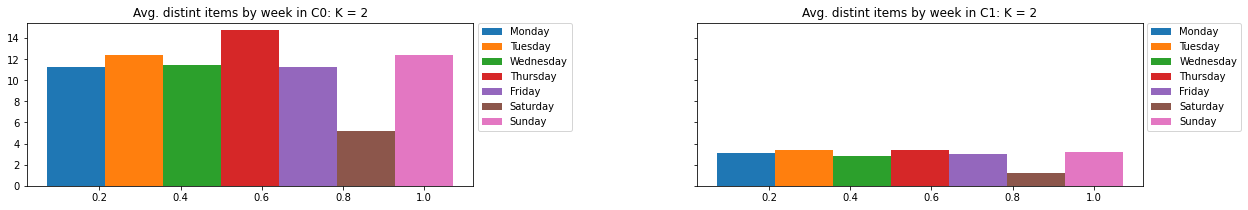

In [28]:
weekdays_bar = [[] for _ in range(Ks[0])]
for j in range(Ks[0]):
    for i in range(1,8):
        weekdays_bar[j].append(cs_clusters[cs_clusters.C2 == j][cs_cat.columns[i]].mean())

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,3), sharey=True)
f.subplots_adjust(wspace=0.5)

for j in range(Ks[0]):
    for i in range(1,8):
        point = (1/len(weekdays_bar[j]) * i)
        axs[j].bar(point, weekdays_bar[j][i-1], 1/len(weekdays_bar[j]), label=cs_cat.columns[i])
    axs[j].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    axs[j].set_title('Avg. distint items by week in C' + str(j) + ': K = ' + str(Ks[0]))



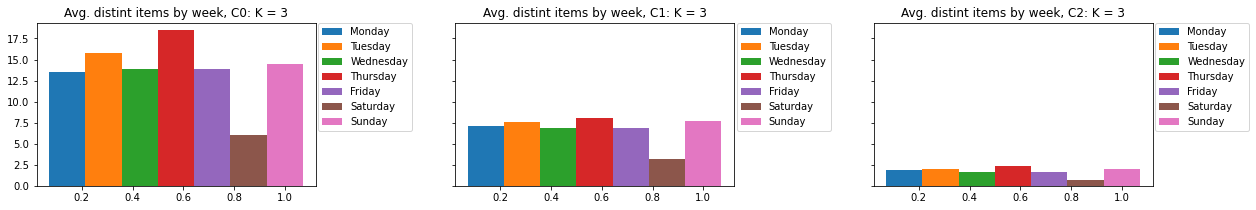

In [29]:
weekdays_bar = [[] for _ in range(Ks[1])]
for j in range(Ks[1]):
    for i in range(1,8):
        weekdays_bar[j].append(cs_clusters[cs_clusters.C3 == j][cs_cat.columns[i]].mean())

f, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,3), sharey=True)
f.subplots_adjust(wspace=0.5)

for j in range(Ks[1]):
    for i in range(1,8):
        point = (1/len(weekdays_bar[j]) * i)
        axs[j].bar(point, weekdays_bar[j][i-1], 1/len(weekdays_bar[j]), label=cs_cat.columns[i])
    axs[j].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    axs[j].set_title('Avg. distint items by week, C' + str(j) + ': K = ' + str(Ks[1]))



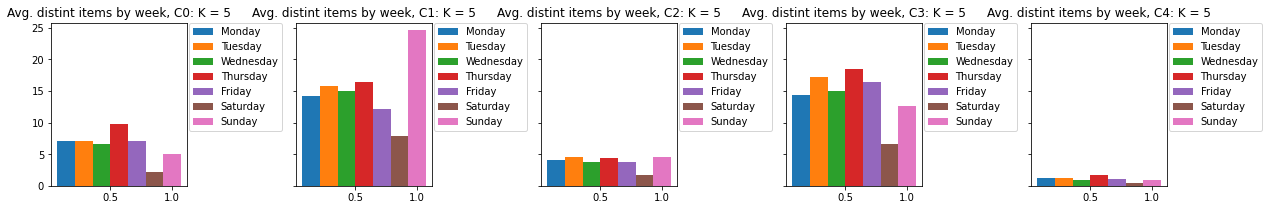

In [30]:
weekdays_bar = [[] for _ in range(Ks[2])]
for j in range(Ks[2]):
    for i in range(1,8):
        weekdays_bar[j].append(cs_clusters[cs_clusters.C5 == j][cs_cat.columns[i]].mean())

f, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,3), sharey=True)
f.subplots_adjust(wspace=0.8)

for j in range(Ks[2]):
    for i in range(1,8):
        point = (1/len(weekdays_bar[j]) * i)
        axs[j].bar(point, weekdays_bar[j][i-1], 1/len(weekdays_bar[j]), label=cs_cat.columns[i])
    axs[j].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    axs[j].set_title('Avg. distint items by week, C' + str(j) + ': K = ' + str(Ks[2]))

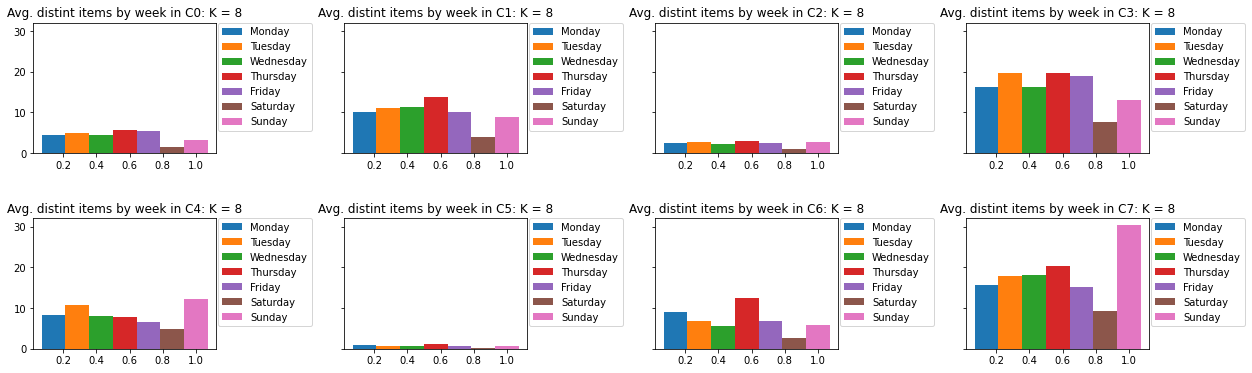

In [31]:
weekdays_bar = [[] for _ in range(Ks[3])]
for j in range(Ks[3]):
    for i in range(1,8):
        weekdays_bar[j].append(cs_clusters[cs_clusters.C8 == j][cs_cat.columns[i]].mean())

f, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,6), sharey=True)
f.subplots_adjust(wspace=0.7, hspace = 0.5)

for j in range(Ks[3]):
    for i in range(1,8):
        point = (1/len(weekdays_bar[j]) * i)
        axs[int(j/4)][j%4].bar(point, weekdays_bar[j][i-1], 1/len(weekdays_bar[j]), label=cs_cat.columns[i])
    axs[int(j/4)][j%4].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    axs[int(j/4)][j%4].set_title('Avg. distint items by week in C' + str(j) + ': K = ' + str(Ks[3]))

#### Visualizing the clusters and the centroids

We now exploit the bidimensional visualization in order to obtain a global view on the clusters and their population. For the sake of providing a meaningful visualization without overburdening the notebook, we build three series scatter plots for specific correlations between pairs of features.

Here you can clearly see the cluster separation and assignment in different colors, and also the centroids in red, so that is is immediate to understand and visualize where the center (i.e. the average value) is located for any cluster.

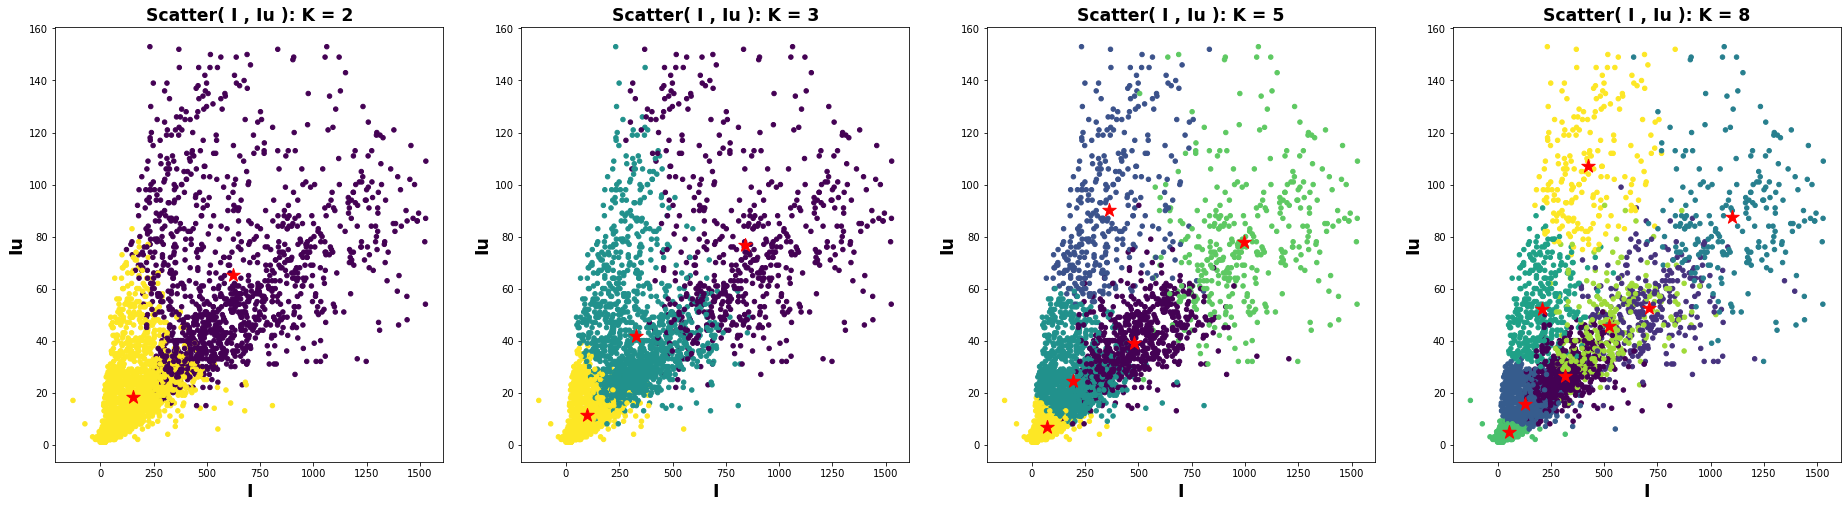

In [32]:
# scatter plots with centroids
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(32,8))
a, b = 0, 1 # we plot the scatter plot of I and Iu
for j in range(4):
    axs[j].scatter(cs_no_out[cs_no_out.columns[a]], cs_no_out[cs_no_out.columns[b]], c=cs_labels[j], s=20)
    for h in range(len(cs_centers[j])):
        axs[j].scatter(cs_centers[j][h][a], cs_centers[j][h][b], s=200, marker='*', c='r')
    axs[j].set_title('Scatter( ' + cs_no_out.columns[a] + ' , ' + cs_no_out.columns[b] + ' ): K = ' + str(Ks[j]), fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
    axs[j].set_xlabel(cs_no_out.columns[a], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
    axs[j].set_ylabel(cs_no_out.columns[b], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})

The graphs above highlight a sparse region of points in the upper part of the 

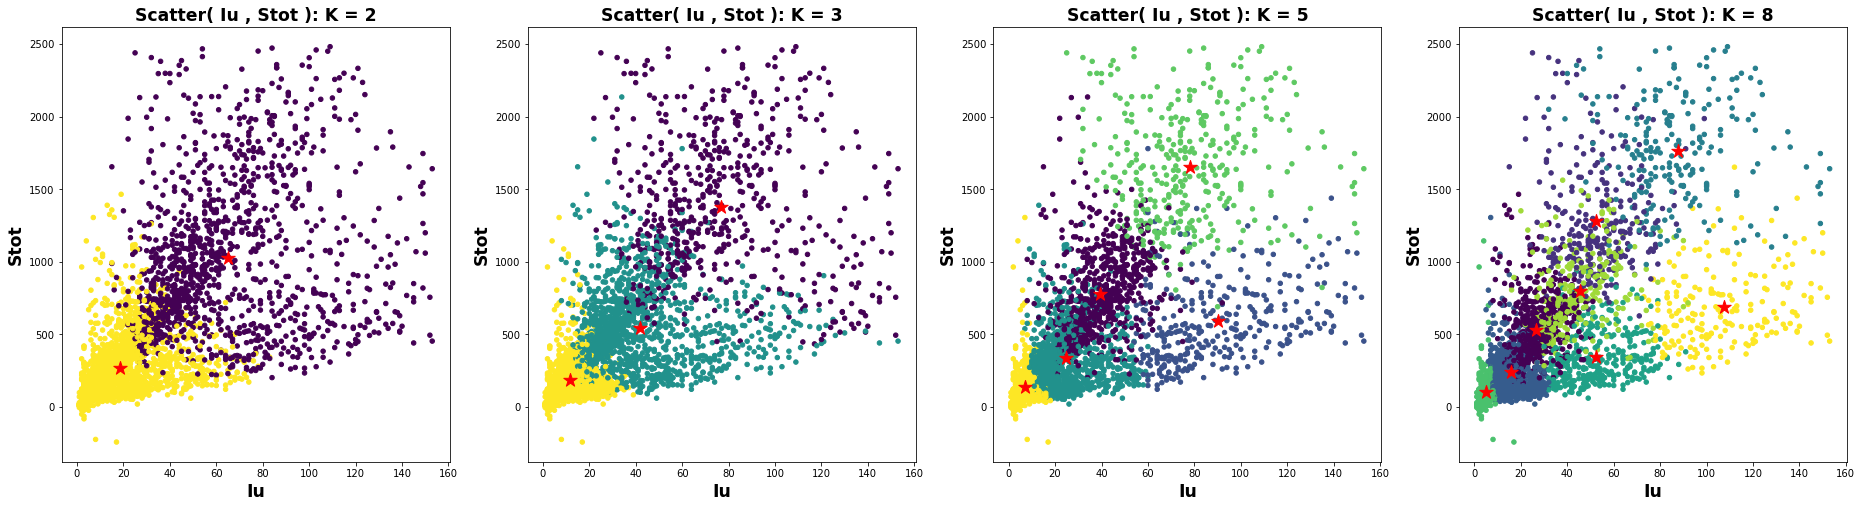

In [33]:
# scatter plots with centroids
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(32,8))
a, b = 1, 4 # we plot the scatter plot of I and Iu
for j in range(4):
    axs[j].scatter(cs_no_out[cs_no_out.columns[a]], cs_no_out[cs_no_out.columns[b]], c=cs_labels[j], s=20)
    for h in range(len(cs_centers[j])):
        axs[j].scatter(cs_centers[j][h][a], cs_centers[j][h][b], s=200, marker='*', c='r')
    axs[j].set_title('Scatter( ' + cs_no_out.columns[a] + ' , ' + cs_no_out.columns[b] + ' ): K = ' + str(Ks[j]), fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
    axs[j].set_xlabel(cs_no_out.columns[a], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
    axs[j].set_ylabel(cs_no_out.columns[b], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})

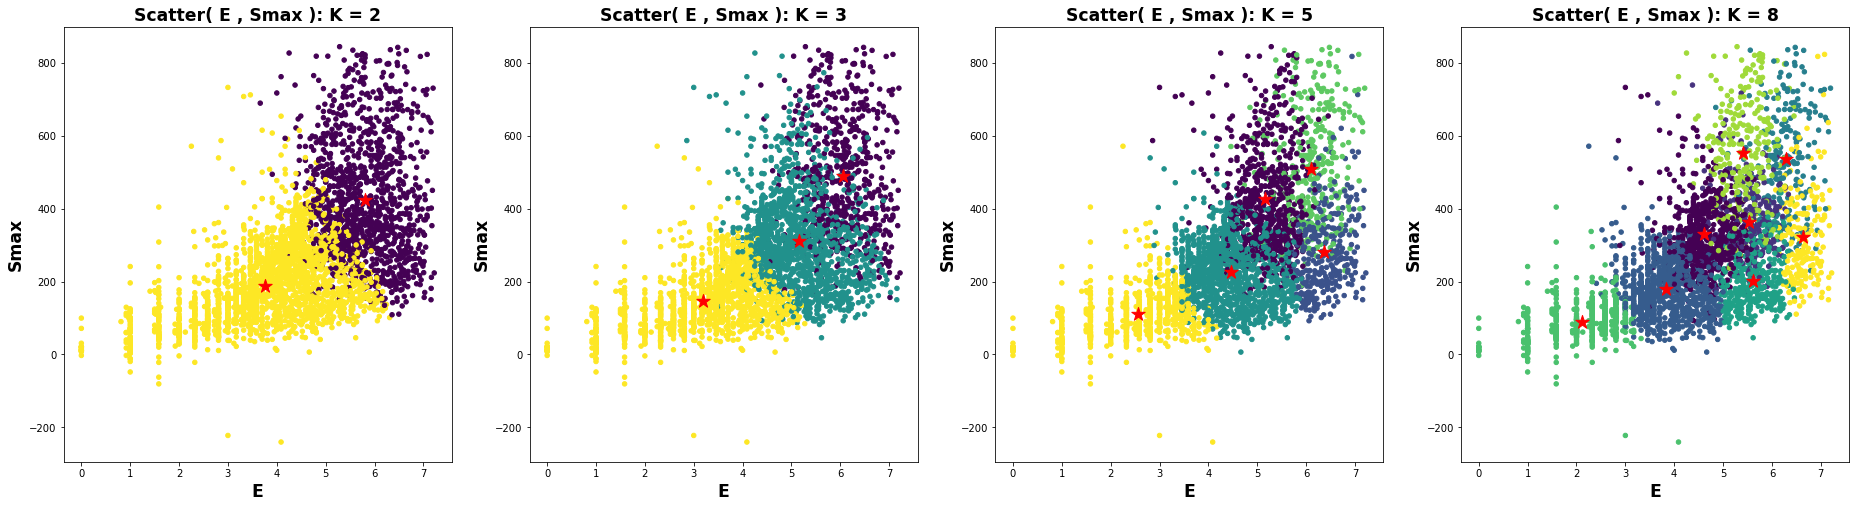

In [34]:
# scatter plots with centroids
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(32,8))
a, b = 3, 5 # we plot the scatter plot of I and Iu
for j in range(4):
    axs[j].scatter(cs_no_out[cs_no_out.columns[a]], cs_no_out[cs_no_out.columns[b]], c=cs_labels[j], s=20)
    for h in range(len(cs_centers[j])):
        axs[j].scatter(cs_centers[j][h][a], cs_centers[j][h][b], s=200, marker='*', c='r')
    axs[j].set_title('Scatter( ' + cs_no_out.columns[a] + ' , ' + cs_no_out.columns[b] + ' ): K = ' + str(Ks[j]), fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
    axs[j].set_xlabel(cs_no_out.columns[a], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
    axs[j].set_ylabel(cs_no_out.columns[b], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})

The graphs above show a sparse region of points at the top of the visualization. Clustering such as that for k equal to 2, 3 or 5 group this region into single clusters and this will certainly have a negative impact on the cohesion index of the latter.

Clustering like that for k equal to 8 instead cover this area with different clusters, thus gaining cohesion but showing a low separation index due to the overlaps in the central area.

## Evaluation of the clustering results
At this point, we are going to use well-known metrics in order to evalueate the clustering obtained with our four versions of k-means. 
Doing this will grant us a numerical expression of the overall "goodness" of the arrangements of out clusters and, again, it'll guide our choice toward which one is the best number of clusters for the optimal partition of this dataset. 

The (internal) evaluation metrics that we are going to compute are:
* **SSE** to measure cohesion
* **Davies Bouldin Score** to measure separation
* **Silhouette Score** to measure them both

### Measuring the cohesion : Sum Squared Error (SSE)


We now use the Sum of Sqare Error in order to measure how closely related are the records in out cluster.

In [35]:
print('Cohesion: ')
for i in range(len(Ks)):
    print('For K = '+ str(Ks[i])+': '+ str(cs_inertia[i]))

Cohesion: 
For K = 2: 339.51481271319767
For K = 3: 247.54979228733333
For K = 5: 167.96345757615452
For K = 8: 120.46045359504424


As previously observed and expected, the SSE of our clusterings tends to decrease with the increase of k. A low value of SSE for k equals to 8 was therefore expected. 
<br>The SSE value for k equals to 5, however, appears relatively low if compared with the one from the other candidates. This could be an indicator of optimal cohesion within the clusters.


### Measuring the separation: Davies Bouldin Score 
We now use the Davies Bouldin Score in order to measure how separated are the records records within different clusters in our clustering.

In [36]:
from sklearn.metrics import davies_bouldin_score
print('Separation (Davies Bouldin Score): ')
for i in range(len(Ks)):
    print('For K = '+ str(Ks[i])+': '+ str(davies_bouldin_score(cs_norm_minmax, cs_labels[i])))

Separation (Davies Bouldin Score): 
For K = 2: 0.9098083061999271
For K = 3: 1.044800874843151
For K = 5: 1.0375703916331118
For K = 8: 1.070315285395994


In terms of separation, the clustering for k equals to 8 seems to be the more promising with k equals to 3 as a relatively close second.

### Measuring both cohesion and separation with the Silhouette Score 
We now use the Silhouette, acting as a measure of both cohesion and separation, in order to evaluate our clustering results.

In [37]:
print('Cohesion and Separation (Silhouette Score): ')
for i in range(len(Ks)):
    print('For K = '+ str(Ks[i])+': '+ str(silhouette_score(cs_norm_minmax, cs_labels[i])))

Cohesion and Separation (Silhouette Score): 
For K = 2: 0.4542955434888357
For K = 3: 0.36011549723922215
For K = 5: 0.33009671684684
For K = 8: 0.3074979325896339


As already observed during our preliminary observations, the clustering for k equals to 2 seems the most promising in terms of Silhouette. 


The latest results certainly make the choice of the optimal k rather conflicting. On the basis of what we have observed during the characterization of the various clusters, however, the choice of this value could be relatively irrelevant if not for reasons related to the field of application of the clustering process itself.

By this we mean that, having assessed that the differences between the populations of the clusters for different values of k are mostly related to the spending power of a customer, the choice of one or the other value of k would simply represent the addition of intermediate classification intervals between the extremes linked to customers with small or large propensity / spending capacity.


## K-means conclusion
What emergeds from the evaluation phase is that our hypotesis (coming from data visualization) that *k*=3 was the optimal choice is definitely confirmed by these numerical results.

### Pros
As sostained by literature, the k-means algorithm converges quickly.
Despite our data does not have globular shape, the results of the partitions was pretty good.


### Cons
The main disadvantage of k-means is that it requires to choose *a priori* the number of clusters to be identified; if the data is not naturally partitioned you get strange results. This human-driven definition for *k* values definitely required a lot of analysis and adjustments: in case of autonomous enstabilishment from the algorithm itself of the correct number of clusters (as we will see for DBSCAN), this entire process would not have been necessary. 

In terms of the quality of the solutions, the algorithm does not guarantee the achievement of the global optimum: the quality of the final solution largely depends on the initial set of groups and can, in practice, obtain a solution much worse than the overall optimum. Since the algorithm is usually extremely fast, it is possible to apply it several times and choose the most satisfactory solution among those produced.

# Clustering analysis by density clustering

The main aim of density-based algorithms is to find **dense regions of space**, i.e. areas in which there is an agglomeration of points.
The notion of density, as well as the way in which we can quantify this "agglomerations", are determined by the choice of parameters.

Density-based clustering methods differ from k-means in the fact that they **do not specify the number of clusters beforehand**. Moreover, unlike other clustering methods, they **incorporate a notion of outliers and are able to “filter” these out**. 

**DBSCAN algorithm**

We perform the density-based clustering using DBSCAN (*Density-Based Spatial Clustering of Applications with Noise*) algorithm.

It has only two parameters...
* **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
* **min_samples**: the minimum number of points needed to create a cluster.

... and one output:
* cluster **labels** for each point in the dataset. Noisy samples are given the label -1.

### Pre-processing
#### Z-Score Normalization

In [38]:
from sklearn.preprocessing import StandardScaler
z_scaler = StandardScaler()
cs_norm_z = z_scaler.fit_transform(cs_no_out.values)

In [39]:
from sklearn.cluster import DBSCAN

In [40]:
# INPUT
dbscan = DBSCAN(eps=0.55, min_samples=15) # algorithmic parameters
dbscan.fit(cs_norm_z)

DBSCAN(algorithm='auto', eps=0.55, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=15, n_jobs=None, p=None)

In [41]:
# OUTPUT
d_labels = []
d_labels.append(dbscan.labels_)
d_labels 

[array([-1, -1,  0, ...,  0,  0, -1], dtype=int64)]

## Parameters tuning 
In order to understand which is the optimal assignment for both the parameters, we had to do a lot of executions and trials, exploring different combinations of values (summarized in a table below).

We tried different values for the *min_sample* parameter (also called *k* in this context) in order to know how many neightbors we had to consider in a region with radius *eps* (second parameter) so that we can appropriately call that region a "cluster".

This process is clearly visible in the plots below.

Then, using the **knee method** we selected the candidates as best values of *eps*, for all the *min_sample* tried.

### Knee method 

**Few neighbors**

Evaluation for: *20 < min_samples < 5*

In [42]:
from scipy.spatial.distance import pdist, squareform
dist = pdist(cs_norm_minmax, 'euclidean') #pair wise distance
print (dist)
dist = squareform(dist) #distance matrix given the vector dist

[0.32753802 0.55102166 0.35888094 ... 0.40155304 0.64593055 1.03918544]


Thanks to visualization tool we can estimate where the value of *eps* parameter gets lower and lower, since it becomes stable. 

In particular, we create several plots experimenting different values for *k* to have a stronger confirm of what are the best associations for different values of *k* and *eps* parameters.

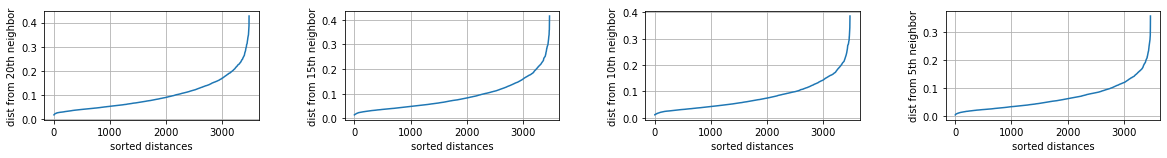

In [43]:
# Set up a grid of plots:
fig = plt.figure(figsize=(20,2))
fig_dims = (1, 4)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

k = 20
    
for i in range(0,1):
    for j in range(0,4):
        plt.subplot2grid(fig_dims, (i,j))
        kth_distances = list()
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])
        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k)
        plt.xlabel('sorted distances')
        plt.tick_params(axis='both', which='major')
        plt.grid(True)
        
        k-=5

From these plots it seems clear that the **candidates values for *eps* parameter are between 0.5 and 1**.

To confirm which is the best one, for each respective *k* quantiy of neightbors, we did a lot of executions, summarized in the table below. 

**Many neightbors**

Evaluation for: *min_samples > 20*

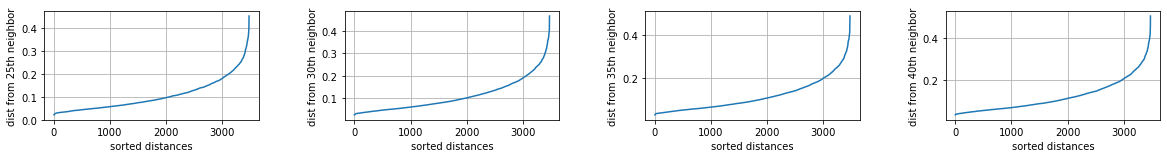

In [44]:
# Set up a grid of plots:
fig = plt.figure(figsize=(20,2))
fig_dims = (1, 4)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

k = 25
    
for i in range(0,1):
    for j in range(0,4):
        plt.subplot2grid(fig_dims, (i,j))
        kth_distances = list()
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])
        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k)
        plt.xlabel('sorted distances')
        plt.tick_params(axis='both', which='major')
        plt.grid(True)
        
        k+=5

Also in the case of many neightbors considered, the *eps* value starts decreasing between 0.5 and 1.

### Executions report

This table summarizes all the trials we did and the respective considerations about the results we obtained.

In [45]:
summary = pd.read_csv('param_tuning.csv', sep=';', index_col=0)
summary

Min neightbors (k)  Eps (between 0.5 and 1.5)  Num of clusters   \
Run                                                                    
1                     5                       0.50                13   
2                     5                       0.75                 6   
3                     5                       0.80                 3   
4                     5                       0.85                 2   
5                     5                       1.00                 2   
6                    10                       0.50                 3   
7                    10                       0.80                 2   
8                    10                       1.00                 8   
9                    10                       1.30                 2   
10                   15                       0.50                 4   
11                   15                       0.55                 3   
12                   15                       0.70                 3   
13                   15                       0.75                 2   
14                   15                       1.00                 2   
15                   20                       0.50                 2   
16                   20                       0.70                 2   
17                   20                       0.75                 2   
18                   20                       0.80                 3   
19                   20                       0.90                 2   
20                   25                       0.50                 2   
21                   25                       0.70                 2   
22                   25                       0.85                 2   
23                   30                       0.77                 2   

     Noisy points  Noise/Clusters ratio  \
Run                                       
1             607                    46   
2             182                    30   
3             138                    46   
4             101                    50   
5              44                    22   
6             850                   283   
7             253                   126   
8            3360                   420   
9              11                     5   
10            997                   249   
11            835                   278   
12            486                   162   
13            399                   199   
14            103                    51   
15           1155                   577   
16            614                   307   
17            483                   241   
18            406                   135   
19            288                   144   
20           1229                   614   
21            663                   331   
22            408                   204   
23            573                   286   

                                        Considerations  
Run                                                     
1                                    Too many clusters  
2                                              Overfit  
3                                              Overfit  
4                                              Overfit  
5                                              Overfit  
6    Some noise in dense region, but nice visualiza...  
7                                              Overfit  
8                          Too many clusters, underfit  
9                                              Overfit  
10   Some noise in dense region, but nice visualiza...  
11                                                Nice  
12                                                Nice  
13                                                Nice  
14                                             Overfit  
15                                            Underfit  
16   Some noise in dense region, but nice visualiza...  
17                                               Great  
18                                           

The executions commented with *overfit* are those with too few noisy point detected with respect to the number of clusters found (viceversa for *underfit* comment).

### Best configuration of parameters
What emerges from the previous analysis on parameters tuning (further supported by some tests on data visualization that we did in this preliminary phase) is that the best combination of parameters to use with this dataset to perform the DBSCAN algorithm are:

- **case1**: *min_sample* = 5, *eps* = 0.86
- **case2**: *min_sample* = 20, *eps* = 0.75 (and some equivalent configurations with the same ratio between number of clusters and noise discovered, like this one:  min_sample = 25, eps = 0.7)  


Both the configurations returned a number of clusters equal to 2.

As a matter of fact, this combo **returns the best balance between noise points and number of clusters detected**.

### Two possible noise interpretations
These two cases are different in the way in which noise can be interpreted. Depending on these interpretations, both correct, we can recognize two possible outcomes:

* *Interpretation of case1*: even if there are both more-dense and less-dense regions, since DBSCAN in not able to recognize them as two separate clusters (as explained before), the algorithm creates a unique cluster which includes both, labeled with 0. The remaining points (assigned to -1 label) represents what we properly call *noise*, i.e. data points that are really far from the dense area.

* *Interpretation of case2*: since DBSCAN is not able to recognize clusters with diffrent densities, it assigns the most dense region to label 0 and the remaining region (less dense) to the label -1 : in this case, the meaning of the label -1 is *not* representing the usual definition of *noise*, but just the **inability of DBSCAN to recognize two different clusters with different densities**.

We will support these hypoteses using data visualization tool (see scatter plots below).

### Running DBSCAN with different parameters

In [46]:
cs_norm_z

array([[-0.04914018, -0.26490132,  0.29841947,  0.1921923 ,  0.37998243,
         1.69495694],
       [ 0.38366226, -0.36357243, -0.49646789, -0.12378177,  1.13474616,
         0.12377101],
       [-0.89144031, -0.88981833, -1.01487269, -1.04100829, -0.70636547,
        -0.51020598],
       ...,
       [-0.41868688, -0.59380501,  0.21201867, -0.27682266, -0.43605121,
         0.28579258],
       [-0.96801305, -0.9227087 , -1.21359453, -1.23391953, -0.91640804,
        -1.12872155],
       [ 0.59673422,  0.031112  ,  2.84724307,  0.48384888,  0.3668061 ,
         2.64997884]])

In [47]:
eps_values = [0.86, 0.75]
min_samples_values = [5, 20]
dbscan = [] 

for i in range(len(eps_values)): 
    d = DBSCAN(eps=eps_values[i], min_samples=min_samples_values[i]) # algorithmic parameters
    dbscan.append(d)
    dbscan[i].fit(cs_norm_z)

In [48]:
dbscan

[DBSCAN(algorithm='auto', eps=0.86, leaf_size=30, metric='euclidean',
        metric_params=None, min_samples=5, n_jobs=None, p=None),
 DBSCAN(algorithm='auto', eps=0.75, leaf_size=30, metric='euclidean',
        metric_params=None, min_samples=20, n_jobs=None, p=None)]

## Statistics
Since density-based clustering algorithms do not have the possibility of deciding *a priori* the number of clusters, we must print the labels' population in order to see **how many clusters** the algorithm has found and also the **size** of each of them (i.e. how many points each cluster contains).

As further informations, we also print how much noise the algorithm has detected for each run.

In [49]:
dbscan_complete = pd.DataFrame()

number_of_classes = []
n_noise = []
dbs_run=[]

for i in range(len(eps_values)): 
    number_of_classes.append(np.unique(dbscan[i].labels_).shape[0])
    n_noise.append(list(dbscan[i].labels_).count(-1))
    dbs_run.append(i+1)

In [50]:
dbscan_complete['DBSCAN case'] = dbs_run
dbscan_complete['K'] = min_samples_values
dbscan_complete['Eps'] = eps_values
dbscan_complete['Number of clusters'] = number_of_classes

In [51]:
dbscan_population = []
for i in range(len(eps_values)): 
    dbscan_population.append(list(dbscan[i].labels_).count(0))

dbscan_complete['Noise label'] = -1
dbscan_complete['Noise population'] = n_noise
dbscan_complete['Cluster label'] = 0
dbscan_complete['Cluster population'] = dbscan_population

dbscan_complete

DBSCAN case   K   Eps  Number of clusters  Noise label  Noise population  \
0            1   5  0.86                   2           -1               107   
1            2  20  0.75                   2           -1               480   

   Cluster label  Cluster population  
0              0                3370  
1              0                2997

### Visualization of density-based clustering in two dimensions

#### Scatter plots

Now we plot all the features correlations in order to fully visualize all the dense regions detected and the noise.

#### Case1: *k* = 5 and *eps* = 0.86

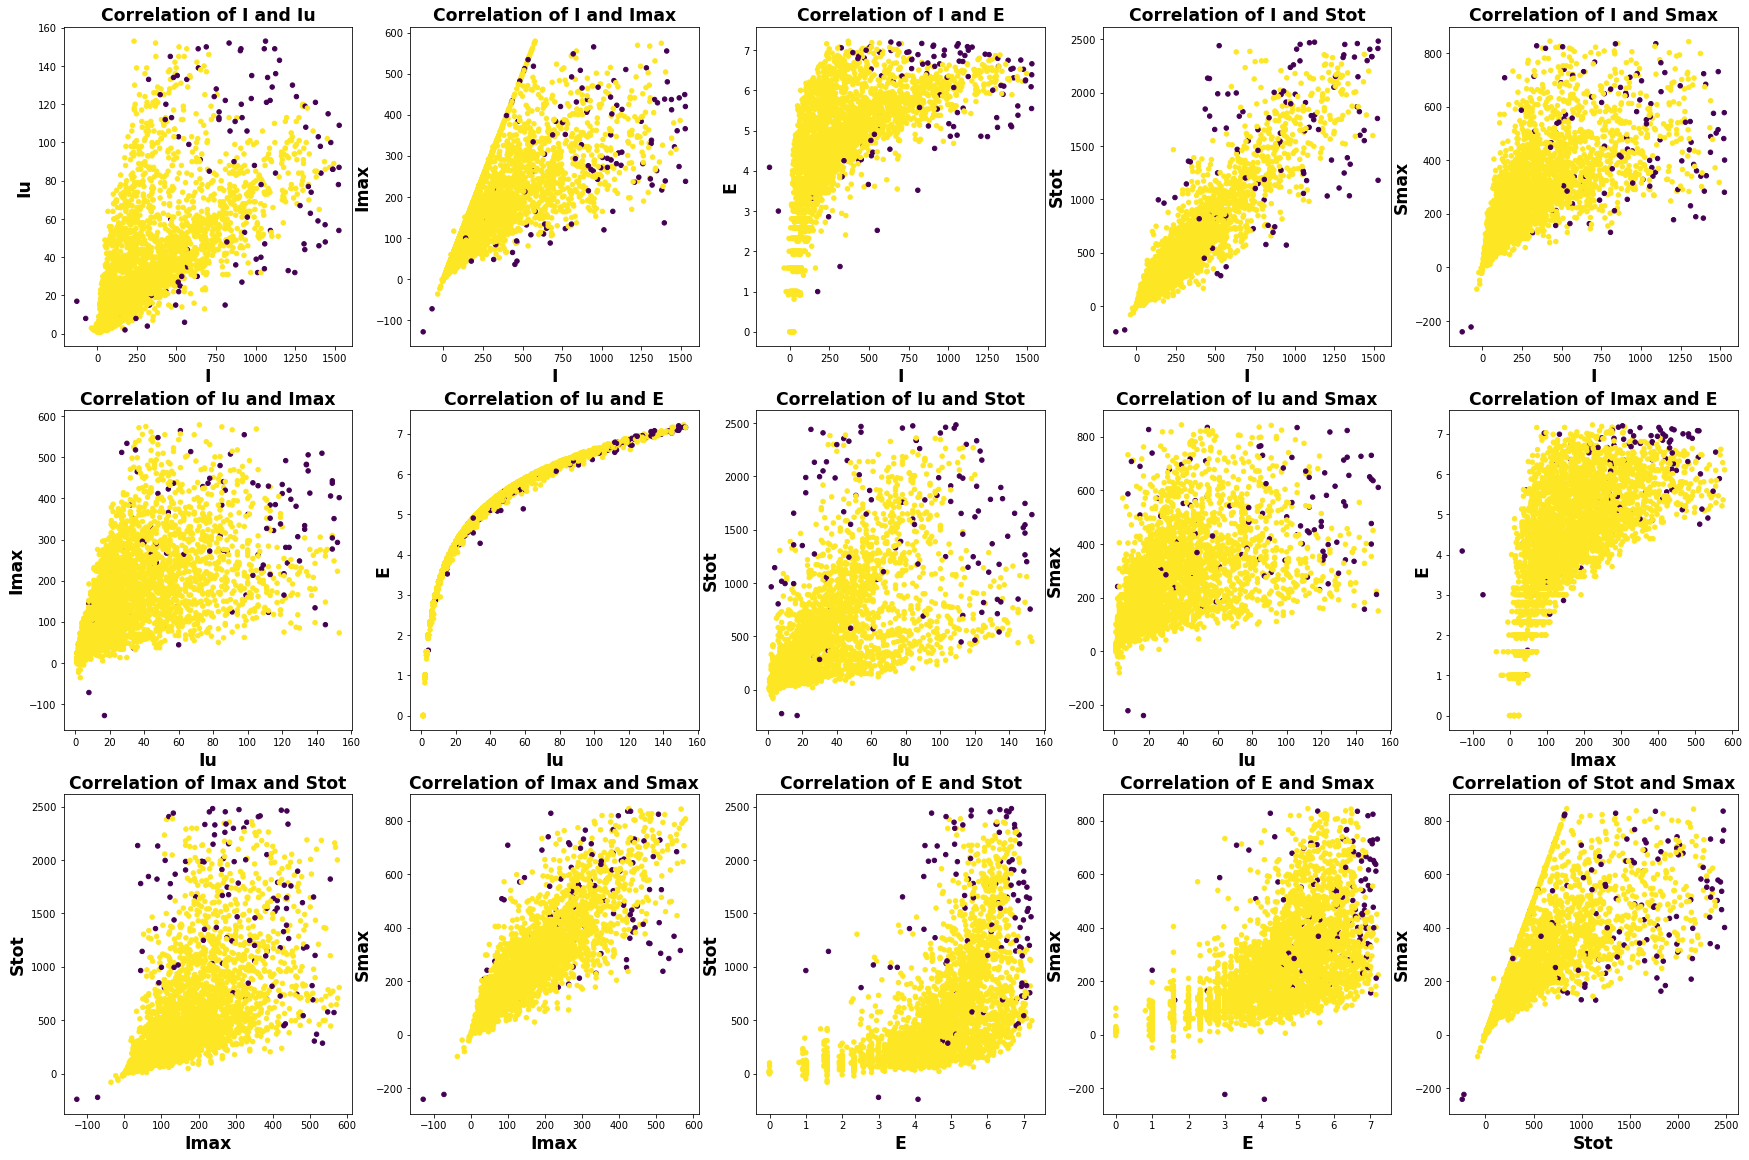

In [52]:
f, axs = plt.subplots(nrows=3, ncols=5, figsize=(30,20))
index = 0
for i in range(0,len(cs_no_out.columns)):
    for j in range(i+1,len(cs_no_out.columns)):
        axs[int(index/5)][index%5].scatter(cs_no_out[cs_no_out.columns[i]], cs_no_out[cs_no_out.columns[j]], c=dbscan[0].labels_, s=20)
        axs[int(index/5)][index%5].set_title('Correlation of ' + cs_no_out.columns[i] + ' and ' + cs_no_out.columns[j], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
        axs[int(index/5)][index%5].set_xlabel(cs_no_out.columns[i], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
        axs[int(index/5)][index%5].set_ylabel(cs_no_out.columns[j], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
        index = index + 1

It is easy to see that DBSCAN is not able to distinguish more-dense and less-dense regions as different clusters (as opposed to k-means that did it properly): so it groups them into a unique cluster (the yellow one). In this situation, data points labeled with -1 are *literally* noise points. 

#### Case2: *k* = 20 and *eps* = 0.75

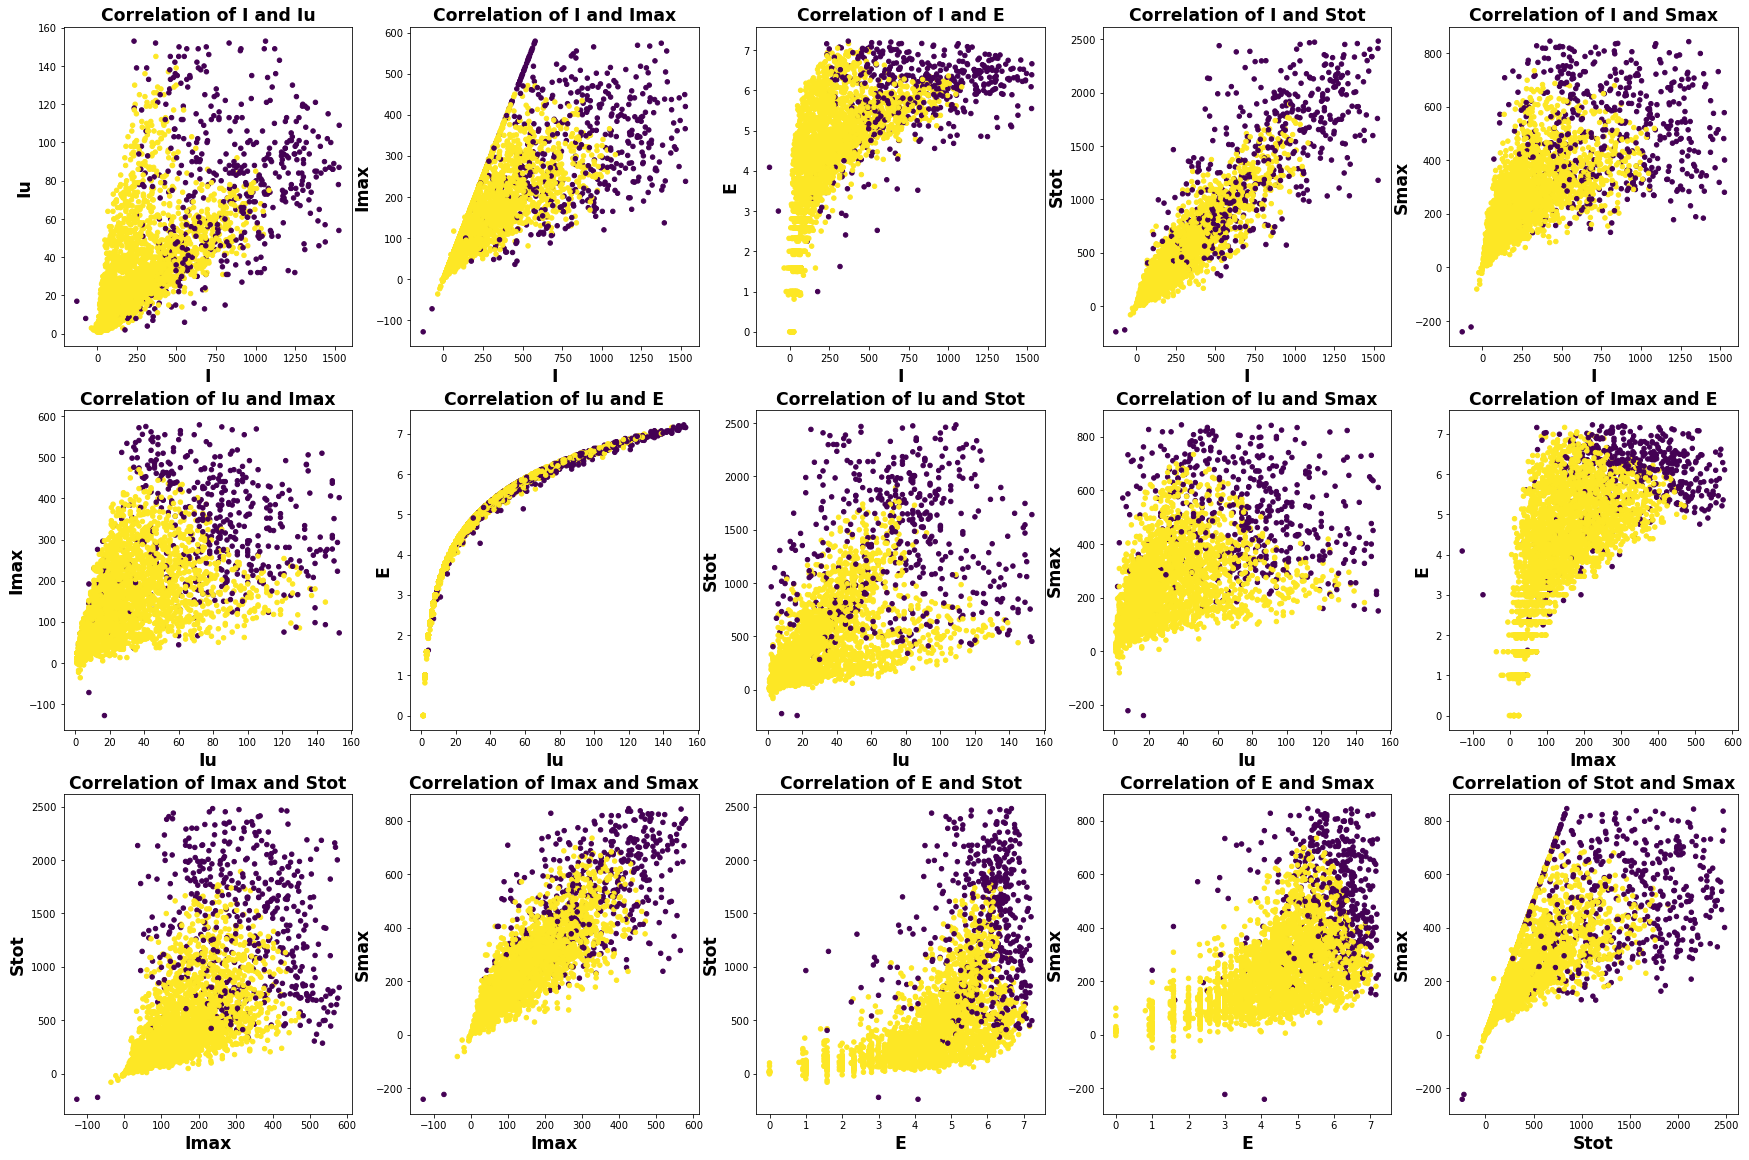

In [53]:
f, axs = plt.subplots(nrows=3, ncols=5, figsize=(30,20))
index = 0
for i in range(0,len(cs_no_out.columns)):
    for j in range(i+1,len(cs_no_out.columns)):
        axs[int(index/5)][index%5].scatter(cs_no_out[cs_no_out.columns[i]], cs_no_out[cs_no_out.columns[j]], c=dbscan[1].labels_, s=20)
        axs[int(index/5)][index%5].set_title('Correlation of ' + cs_no_out.columns[i] + ' and ' + cs_no_out.columns[j], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
        axs[int(index/5)][index%5].set_xlabel(cs_no_out.columns[i], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
        axs[int(index/5)][index%5].set_ylabel(cs_no_out.columns[j], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
        index = index + 1

Here the inability of DBSCAN to clusterize together the two regions with different densities is interpreted in another way: since it cannot assign a separate cluster to the less-dense region, it automatically assigns to it the lable -1. But, coherently with this interpretation, -1 points are not properly *noise*, but the representation of the algorithm's limitation.

## Post-processing analysis
### Comments on data visualization results



* **Robustness to noise**. It is clearly evident one of the major advantage of the density-based clustering: it is able to detect whatever it recognizes as noise and to label it as -1.
* **Ability to capture clusters with different shapes**. The yellow cluster is clearly a non-globular cluster but DBSCAN can easily detect it.
* **Unable to detect variable densities**. This is a well known limitation of DBSCAN algorithm, and here we have the opportunity to clearly see it: in the second interpretation we proposed, the 'agglomerate' in yellow is the most dense part and so it is correctly recognized as a cluster, but the purple one is classified as noise just because it is less dense that the other. To make a comparison, k-means algorithm instead classified that region as a separate cluster.

### Evaluation with internal metrics
Now we reinfoce this observations based on data viasualization with numerical informations. We start computing internal indexes and then we proceed also in computing external ones.

#### Silhouette and separation score

The silouhette score describes not only the cohesion but also separation between clusters (it is able to capture if clusters are well separated or not).

A value of silhouette equal to 1 means that there is a good cohesion and separation between clusters.

In [54]:
from sklearn import metrics

sil = []
sep = []

for i in range(len(eps_values)): 
    # print statistics
    sil.append(silhouette_score(cs_norm_z, dbscan[i].labels_))
    sep.append(metrics.davies_bouldin_score(cs_norm_z, dbscan[i].labels_))

dbscan_complete['Silhouette'] = sil
dbscan_complete['Separation'] = sep
dbscan_complete

DBSCAN case   K   Eps  Number of clusters  Noise label  Noise population  \
0            1   5  0.86                   2           -1               107   
1            2  20  0.75                   2           -1               480   

   Cluster label  Cluster population  Silhouette  Separation  
0              0                3370    0.395698    1.327654  
1              0                2997    0.435100    1.061300

The result shows that the two obtained clusters are well-separated, expecially in case1, but not so cohesive.

### Evaluation with external metrics
We now introduce again categorical features to interprete clusters' semantic and to understand how they are distributed.

**External indexes**

The metrics that we are going to use are:
- **Similarity** between original features and labels found by the algorithm.
- **Homogeneity** that measures if clusters are homogeneous wrt class labels. A value equal to 1 means that cluster are of the same type of the original label (i.e. categorical feature).
- **Completeness** measures how much original labels are concentrated in specific clusters.
- **Mutual Information** is a function that measures the agreement of the two assignments (i.e. original classes and labels assigned by the algorithm), ignoring permutations.

#### External metrics evaluation for DBSCAN case1

In [55]:
from sklearn import metrics

dbs1=pd.DataFrame()
dbs2=pd.DataFrame()

temp=[]
sim=[[],[]]
hom=[[],[]]
compl=[[],[]]
mutinfo=[[],[]]

for column in cs_cat:
    temp.append(column)
    for i in range(2):
        sim[i].append(metrics.adjusted_rand_score(cs_cat[column], dbscan[i].labels_))
        hom[i].append(metrics.homogeneity_score(cs_cat[column], dbscan[i].labels_))
        compl[i].append(metrics.completeness_score(cs_cat[column], dbscan[i].labels_))
        mutinfo[i].append(metrics.normalized_mutual_info_score(cs_cat[column], dbscan[i].labels_, average_method='arithmetic'))
    
dbs1['Feature'] = temp
dbs1['Similarity'] = sim[0]
dbs1['Homogeneity'] = hom[0]
dbs1['Completeness'] = compl[0]
dbs1['Mutual Information'] = mutinfo[0]
        
print('\n\nExternal metrics for DBSCAN case 1')
dbs1



External metrics for DBSCAN case 1


Feature  Similarity  Homogeneity  Completeness  Mutual Information
0     Country   -0.005855     0.005945      0.022691            0.009422
1      Monday    0.032449     0.008556      0.112295            0.015900
2     Tuesday    0.038545     0.009970      0.139519            0.018610
3   Wednesday    0.049451     0.012196      0.157537            0.022639
4    Thursday    0.024553     0.007667      0.118947            0.014406
5      Friday    0.050612     0.010801      0.144698            0.020102
6    Saturday    0.050268     0.012183      0.081663            0.021203
7      Sunday    0.045560     0.011749      0.150060            0.021792
8     January    0.048647     0.010489      0.079782            0.018540
9    February    0.036531     0.009824      0.071243            0.017267
10      March    0.040346     0.007567      0.061289            0.013471
11      April    0.068985     0.013662      0.100082            0.024043
12        May    0.060602     0.012360      0.106300            0.022145
13       June    0.058014     0.011776      0.105514            0.021187
14       July    0.075355     0.015063      0.135255            0.027106
15     August    0.070549     0.013022      0.106377            0.023204
16  September    0.053804     0.011958      0.126057            0.021844
17    October    0.036269     0.010459      0.113521            0.019153
18   November    0.048612     0.010830      0.135809            0.020061
19   December    0.074209     0.012019      0.073653            0.020666
20    Weekday    0.000269     0.000882      0.012179            0.001645
21      Month   -0.000577     0.001244      0.022112            0.002355

#### External metrics evaluation for DBSCAN case2

In [56]:
dbs2['Feature'] = temp
dbs2['Similarity'] = sim[1]
dbs2['Homogeneity'] = hom[1]
dbs2['Completeness'] = compl[1]
dbs2['Mutual Information'] = mutinfo[1]

print('\n\nExternal metrics for DBSCAN case 2')
dbs2



External metrics for DBSCAN case 2


Feature  Similarity  Homogeneity  Completeness  Mutual Information
0     Country    0.003650     0.008628      0.011274            0.009775
1      Monday    0.088484     0.016329      0.073373            0.026713
2     Tuesday    0.110420     0.020533      0.098374            0.033975
3   Wednesday    0.118053     0.019564      0.086515            0.031911
4    Thursday    0.085752     0.020810      0.110522            0.035025
5      Friday    0.111433     0.019859      0.091078            0.032608
6    Saturday    0.111082     0.025371      0.058220            0.035341
7      Sunday    0.109098     0.022152      0.096860            0.036057
8     January    0.097741     0.018813      0.048990            0.027186
9    February    0.105444     0.020035      0.049740            0.028564
10      March    0.098111     0.019931      0.055266            0.029297
11      April    0.114667     0.020696      0.051902            0.029592
12        May    0.133337     0.024156      0.071125            0.036064
13       June    0.110431     0.015886      0.048732            0.023961
14       July    0.124305     0.021418      0.065842            0.032322
15     August    0.130748     0.023511      0.065751            0.034637
16  September    0.131460     0.024854      0.089693            0.038922
17    October    0.096102     0.017891      0.066481            0.028195
18   November    0.110272     0.019990      0.085818            0.032427
19   December    0.140442     0.025420      0.053330            0.034430
20    Weekday   -0.000250     0.000592      0.002800            0.000978
21      Month   -0.000886     0.000771      0.004691            0.001324

What we get from this analysis is that

### Characterization of the obtained clusters
**Classification via categorical attributes**

In order to understand even better how categorical features are distributed with respect to DBSCAN executions results, we now build some cross tables and barplots.

We report a complete analysis for each categorical attribute.

### Country attribute

In [57]:
cross_Country=[]
# Create cross tables
for i in range(len(eps_values)): 
    cross_Country.append(pd.crosstab(dbscan[i].labels_, cs_cat.Country))

In [58]:
# useful changes for visualization
for i in range(len(eps_values)):
    cs_clusters['DBS' + str(i+1)] = dbscan[i].labels_

#### Clusters and noise interpretation by country for DBSCAN case1


We now plot customers informations related to DBSCAN case 1:
 DBSCAN case              1.000000
K                        5.000000
Eps                      0.860000
Number of clusters       2.000000
Noise label             -1.000000
Noise population       107.000000
Cluster label            0.000000
Cluster population    3370.000000
Silhouette               0.395698
Separation               1.327654
Name: 0, dtype: float64 




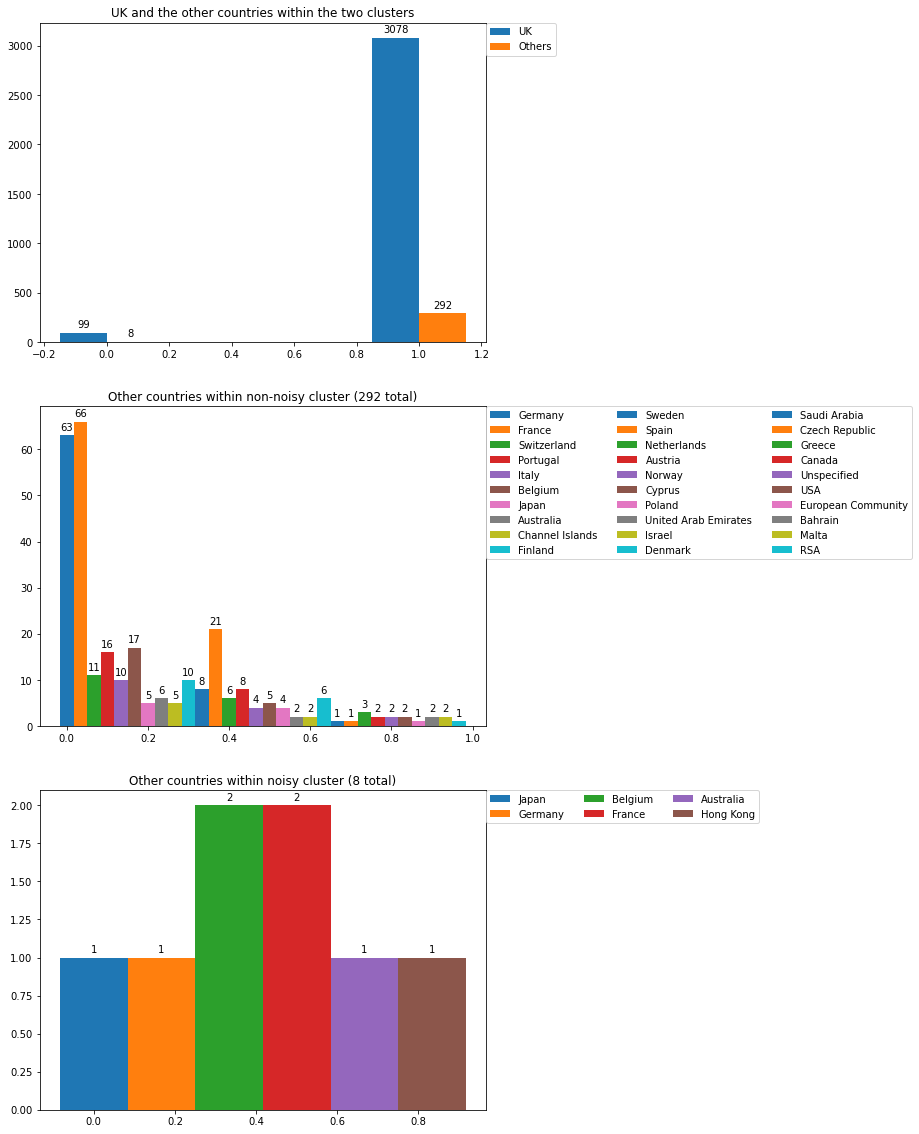

In [59]:
d_visual_labels=['Cluster 1', 'Cluster 2']

UK_bar = cs_clusters[cs_clusters.Country == 'United Kingdom'].groupby(['DBS1', 'Country']).size().unstack()
UK_bar['Others'] = pd.DataFrame(cs_clusters[cs_clusters.Country != 'United Kingdom'].groupby(['DBS1']).size())

other_countries = [[] for _ in range(2)]
other_values = [[] for _ in range(2)]
lab =[-1, 0]
for cluster in lab:
    for country in cs_clusters[(cs_clusters.Country != 'United Kingdom') & (cs_clusters.DBS1 == cluster)].Country.unique():
        other_countries[cluster].append(country)
        other_values[cluster].append(cs_clusters[(cs_clusters.DBS1 == cluster) & (cs_clusters.Country == country)].Country.count())
print('\nWe now plot customers informations related to DBSCAN case 1:\n',dbscan_complete.loc[0],'\n\n')
 
x = np.arange(len(d_visual_labels))
width = 0.15

f, axs = plt.subplots(nrows=3, figsize=(8,20))
autolabel(axs[0].bar(x - width/2, UK_bar['United Kingdom'], width, label='UK'), 0)
autolabel(axs[0].bar(x + width/2, UK_bar['Others'], width, label='Others'), 0)
axs[0].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
axs[0].set_title('UK and the other countries within the two clusters')

for i in [1,2]:
    for j in range(len(other_countries[i-1])):
        point = (1/len(other_countries[i-1]) * j)
        autolabel(axs[i].bar( point, other_values[i-1][j], (1/len(other_countries[i-1])), label=other_countries[i-1][j]), i)
        axs[i].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0., ncol=3)
    axs[1].set_title('Other countries within non-noisy cluster (292 total)')
    axs[2].set_title('Other countries within noisy cluster (8 total)')
    
plt.show()

#### Clusters and noise interpretation by country for DBSCAN case2


We now plot customers informations related to DBSCAN case 2:
 DBSCAN case              2.0000
K                       20.0000
Eps                      0.7500
Number of clusters       2.0000
Noise label             -1.0000
Noise population       480.0000
Cluster label            0.0000
Cluster population    2997.0000
Silhouette               0.4351
Separation               1.0613
Name: 1, dtype: float64 




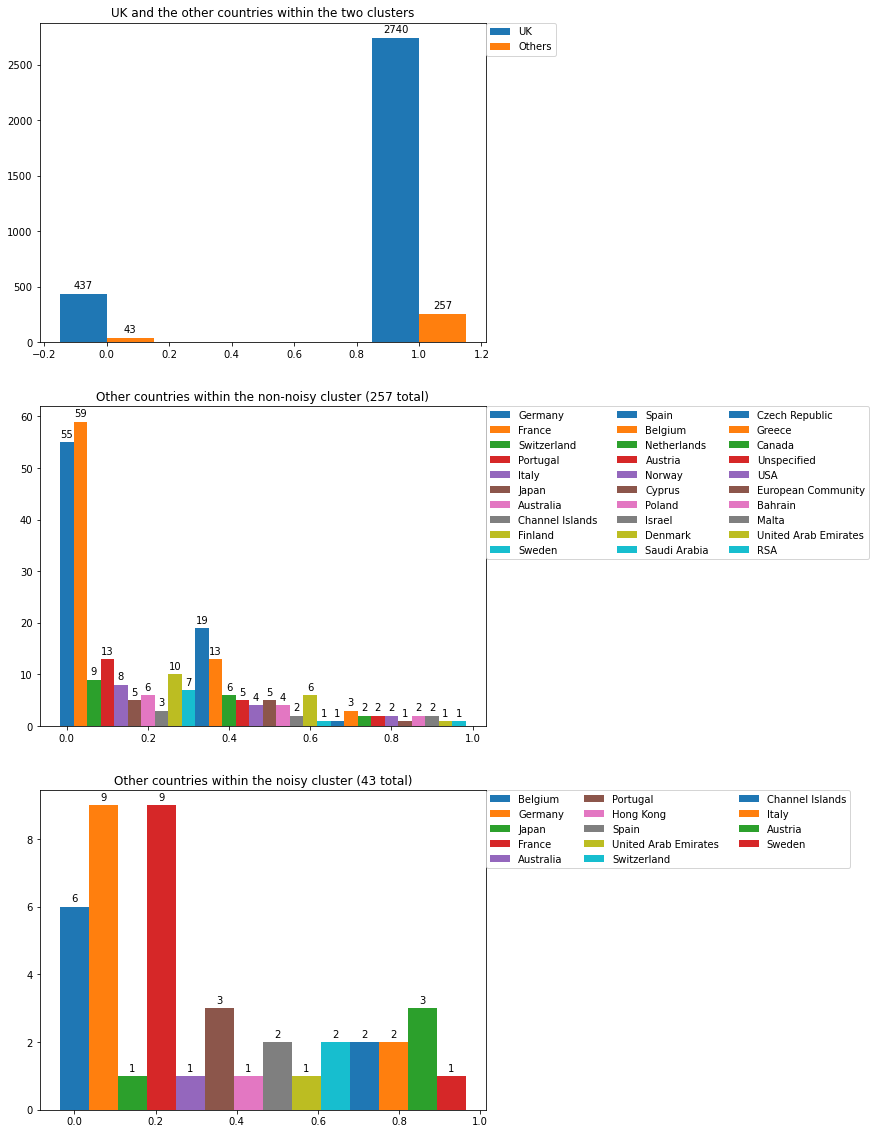

In [60]:
d_visual_labels=['Cluster 1', 'Cluster 2']

UK_bar = cs_clusters[cs_clusters.Country == 'United Kingdom'].groupby(['DBS2', 'Country']).size().unstack()
UK_bar['Others'] = pd.DataFrame(cs_clusters[cs_clusters.Country != 'United Kingdom'].groupby(['DBS2']).size())

other_countries = [[] for _ in range(2)]
other_values = [[] for _ in range(2)]
lab =[-1, 0]
for cluster in lab:
    for country in cs_clusters[(cs_clusters.Country != 'United Kingdom') & (cs_clusters.DBS2 == cluster)].Country.unique():
        other_countries[cluster].append(country)
        other_values[cluster].append(cs_clusters[(cs_clusters.DBS2 == cluster) & (cs_clusters.Country == country)].Country.count())

print('\nWe now plot customers informations related to DBSCAN case 2:\n',dbscan_complete.loc[1],'\n\n')
 
x = np.arange(len(d_visual_labels))
width = 0.15

f, axs = plt.subplots(nrows=3, figsize=(8,20))
autolabel(axs[0].bar(x - width/2, UK_bar['United Kingdom'], width, label='UK'), 0)
autolabel(axs[0].bar(x + width/2, UK_bar['Others'], width, label='Others'), 0)
axs[0].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
axs[0].set_title('UK and the other countries within the two clusters')

for i in [1,2]:
    for j in range(len(other_countries[i-1])):
        point = (1/len(other_countries[i-1]) * j)
        autolabel(axs[i].bar( point, other_values[i-1][j], (1/len(other_countries[i-1])), label=other_countries[i-1][j]), i)
        axs[i].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0., ncol=3)
    axs[1].set_title('Other countries within the non-noisy cluster (257 total)')
    axs[2].set_title('Other countries within the noisy cluster (43 total)')

### Weekdays attributes
We first check the population of those attributes computed by mode value.

In [61]:
# Create cross table
cross_week=[]
for i in range(len(eps_values)): 
    cross_week.append(pd.crosstab(dbscan[i].labels_, cs_cat.Weekday))

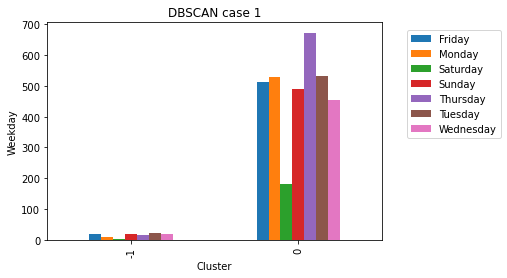

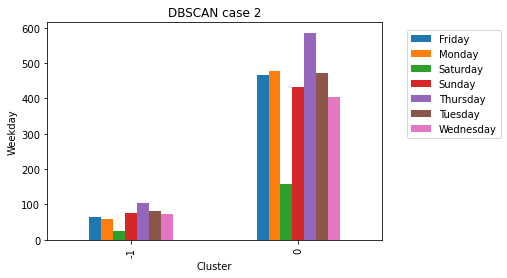

In [62]:
for i in range(len(eps_values)): 
    j=i+1
    cross_week[i].plot(kind='bar', stacked=False, title='DBSCAN case %i' % j)
    plt.xlabel('Cluster')
    plt.ylabel('Weekday')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.8)

This analysis confirms the results we got of k-means post-processing phase: the favourite day for customers to go shopping is Thursday. 

However, DBSCAN clusters result gives us a further information: the algorithm found new days in which the purchasing behavior of customers is high: Monday and Friday. 

#### Cluster and noise interpretations by weekday

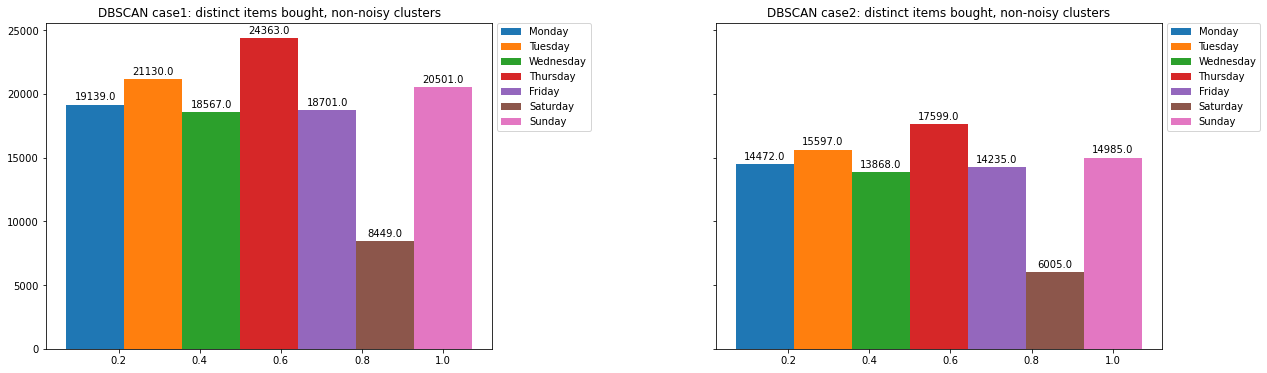

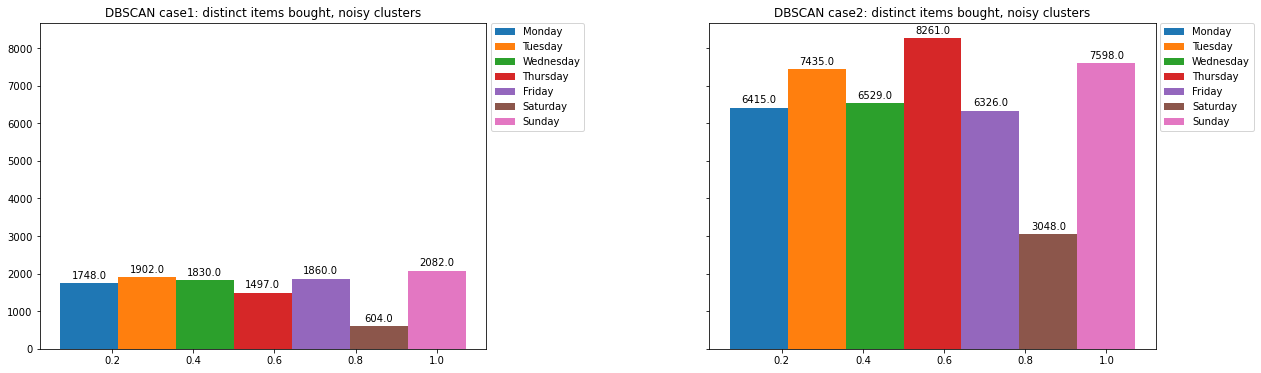

In [63]:
# PLOTS FOR WEEKLY TOTAL ITEMS BOUGHT
weekdays_bar = [[] for _ in range(4)]

for i in range(1,8):
    weekdays_bar[0].append(cs_clusters[cs_clusters.DBS1 == 0][cs_cat.columns[i]].sum())
    weekdays_bar[1].append(cs_clusters[cs_clusters.DBS2 == 0][cs_cat.columns[i]].sum())
    weekdays_bar[2].append(cs_clusters[cs_clusters.DBS1 == -1][cs_cat.columns[i]].sum())
    weekdays_bar[3].append(cs_clusters[cs_clusters.DBS2 == -1][cs_cat.columns[i]].sum())

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6), sharey=True)
f.subplots_adjust(wspace=0.5)

for j in range(2):
    for i in range(1,8):
        point = (1/len(weekdays_bar[j]) * i)
        autolabel(axs[j].bar(point, weekdays_bar[j][i-1], 1/len(weekdays_bar[j]), label=cs_cat.columns[i]), j)
    axs[j].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    axs[j].set_title('DBSCAN case' + str(j+1) + ': distinct items bought, non-noisy clusters')     

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6), sharey=True)
f.subplots_adjust(wspace=0.5)

for j in range(2):
    for i in range(1,8):
        point = (1/len(weekdays_bar[j+2]) * i)
        autolabel(axs[j].bar(point, weekdays_bar[j+2][i-1], 1/len(weekdays_bar[j+2]), label=cs_cat.columns[i]), j)
    axs[j].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    axs[j].set_title('DBSCAN case' + str(j+1) + ': distinct items bought, noisy clusters') 

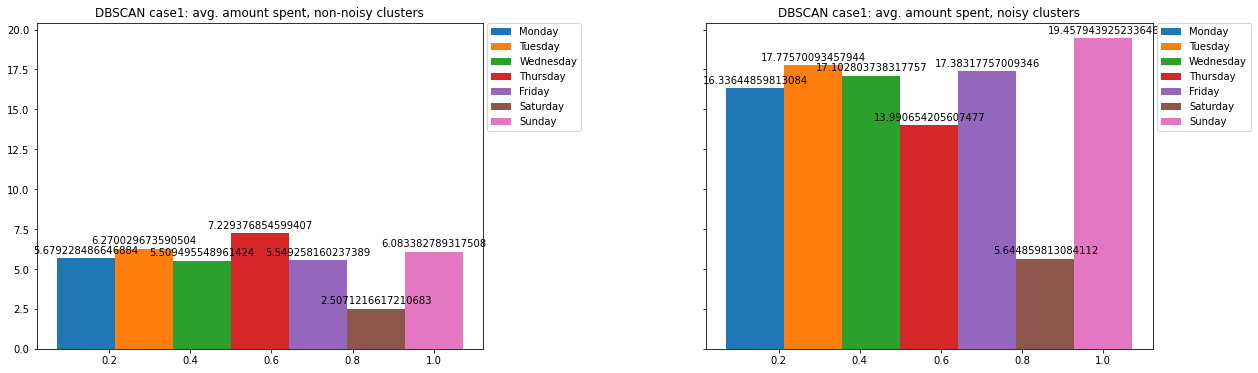

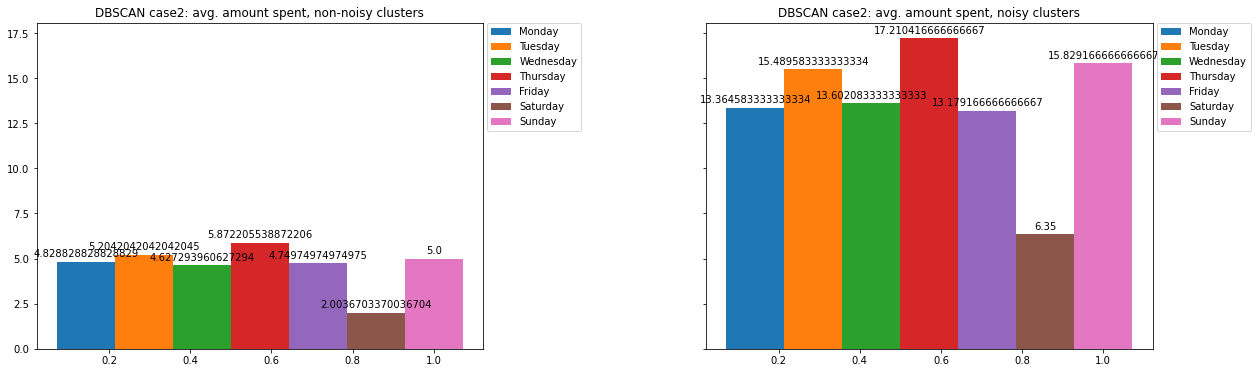

In [64]:
# PLOTS FOR WEEKLY TOTAL SPENT
weekdays=[]
for i in range(1,8):
    weekdays.append(cs_cat.columns[i])
    
w_cust= pd.DataFrame(columns=weekdays)
j=0
for column in w_cust:
    #w_cust[column] =cs_clusters.Stot.groupby([cs_clusters[column]]).sum().transform(lambda x: x/x.mean())
    w_cust[column] =cs_clusters.Stot.groupby([cs_clusters[column]]).sum()
    j+=1
    
weekdays_bar_spent = [[] for _ in range(4)]

for i in range(7):
    weekdays_bar_spent[0].append(cs_clusters[cs_clusters.DBS1 == 0][w_cust.columns[i]].mean())
    weekdays_bar_spent[1].append(cs_clusters[cs_clusters.DBS1 == -1][w_cust.columns[i]].mean())
    weekdays_bar_spent[2].append(cs_clusters[cs_clusters.DBS2 == 0][w_cust.columns[i]].mean())
    weekdays_bar_spent[3].append(cs_clusters[cs_clusters.DBS2 == -1][w_cust.columns[i]].mean())

    
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6), sharey=True)
f.subplots_adjust(wspace=0.5)

for j in range(2):
    for i in range(1,8):
        point = (1/len(weekdays_bar_spent[j]) * i)
        autolabel(axs[j].bar(point, weekdays_bar_spent[j][i-1], 1/len(weekdays_bar_spent[j]), label=cs_cat.columns[i]), j)
    axs[j].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    #axs[j].set_title('DBSCAN case' + str(j+1) + ': total spent, non-noisy clusters') 
    axs[0].set_title('DBSCAN case' + str(1) + ': avg. amount spent, non-noisy clusters')
    axs[1].set_title('DBSCAN case' + str(1) + ': avg. amount spent, noisy clusters')

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6), sharey=True)
f.subplots_adjust(wspace=0.5)

for j in range(2):
    for i in range(1,8):
        point = (1/len(weekdays_bar_spent[j+2]) * i)
        autolabel(axs[j].bar(point, weekdays_bar_spent[j+2][i-1], 1/len(weekdays_bar_spent[j+2]), label=cs_cat.columns[i]), j)
    axs[j].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title('DBSCAN case' + str(2) + ': avg. amount spent, non-noisy clusters')
    axs[1].set_title('DBSCAN case' + str(2) + ': avg. amount spent, noisy clusters')
    #axs[j].set_title('DBSCAN case' + str(j+1) + ': total spent, noisy clusters') 

### Month attribute
We first check the population of those attributes computed by mode value.

In [65]:
# Create cross table
cross_month=[]
for i in range(len(eps_values)): 
    cross_month.append(pd.crosstab(dbscan[i].labels_, cs_cat.Month))

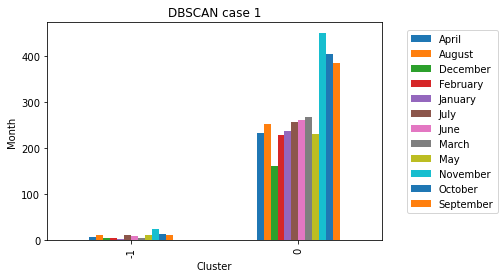

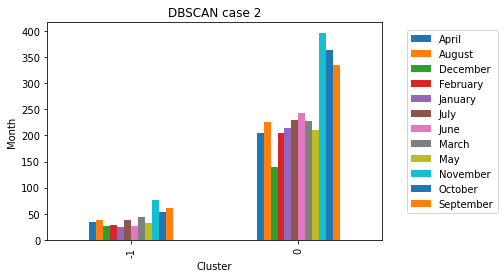

In [66]:
for i in range(len(eps_values)): 
    j=i+1
    cross_month[i].plot(kind='bar', stacked=False, title='DBSCAN case %i' % j)
    plt.xlabel('Cluster')
    plt.ylabel('Month')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.8)

Again the results of k-means algorithm are totally confirmed: DBSCAN too has discovered that the best month to make purchases are the fall-month (September, October, and mostly November).

#### Cluster and noise interpretations by month

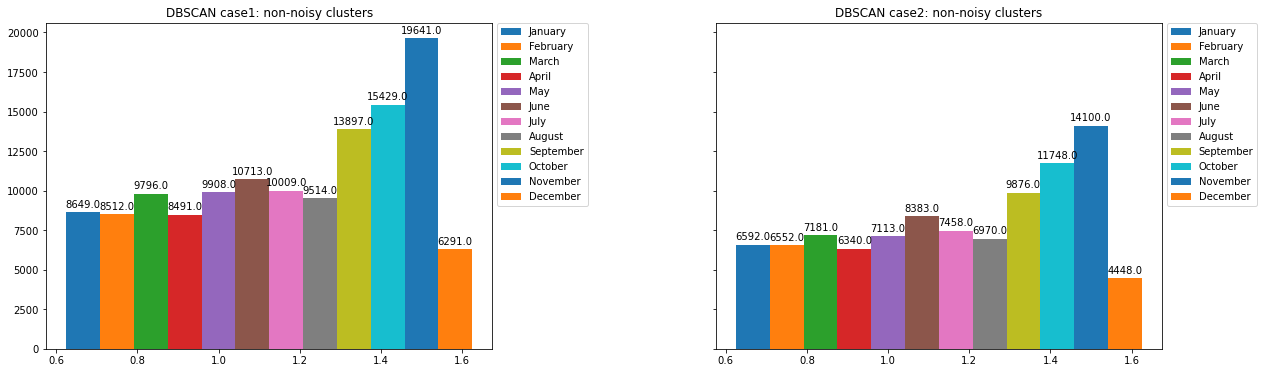

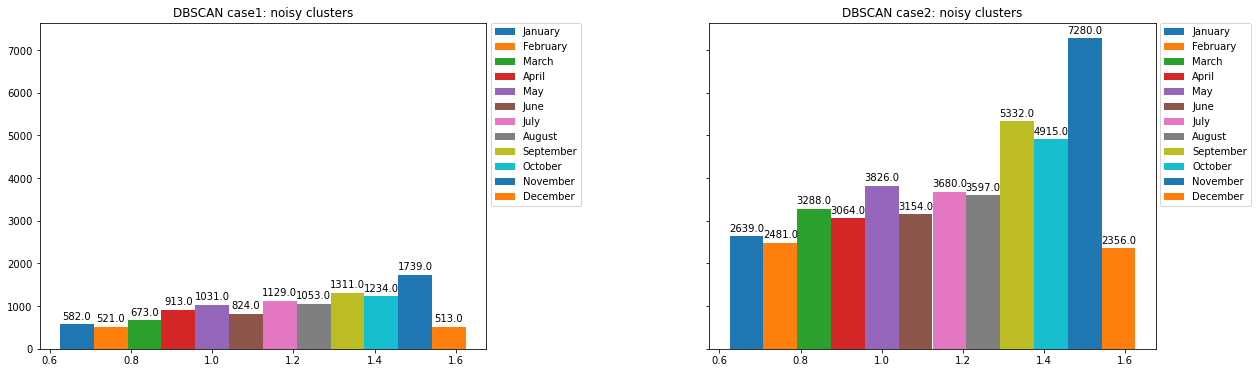

In [67]:
# PLOTS FOR MONTHLY TOTAL ITEMS BOUGHT

months_bar = [[] for _ in range(4)]

for i in range(8,20):
    months_bar[0].append(cs_clusters[cs_clusters.DBS1 == 0][cs_cat.columns[i]].sum())
    months_bar[1].append(cs_clusters[cs_clusters.DBS2 == 0][cs_cat.columns[i]].sum())
    months_bar[2].append(cs_clusters[cs_clusters.DBS1 == -1][cs_cat.columns[i]].sum())
    months_bar[3].append(cs_clusters[cs_clusters.DBS2 == -1][cs_cat.columns[i]].sum())
        
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6), sharey=True)
f.subplots_adjust(wspace=0.5)

for j in range(2):
    for i in range(8,20):
        point = (1/len(months_bar[j]) * i)
        autolabel(axs[j].bar(point, months_bar[j][i-8], 1/len(months_bar[j]), label=cs_cat.columns[i]), j)
    axs[j].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    axs[j].set_title('DBSCAN case' + str(j+1) + ': non-noisy clusters')
    
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6), sharey=True)
f.subplots_adjust(wspace=0.5)

for j in range(2):
    for i in range(8,20):
        point = (1/len(months_bar[j+2]) * i)
        autolabel(axs[j].bar(point, months_bar[j+2][i-8], 1/len(months_bar[j+2]), label=cs_cat.columns[i]), j)
    axs[j].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    axs[j].set_title('DBSCAN case' + str(j+1) + ': noisy clusters')   

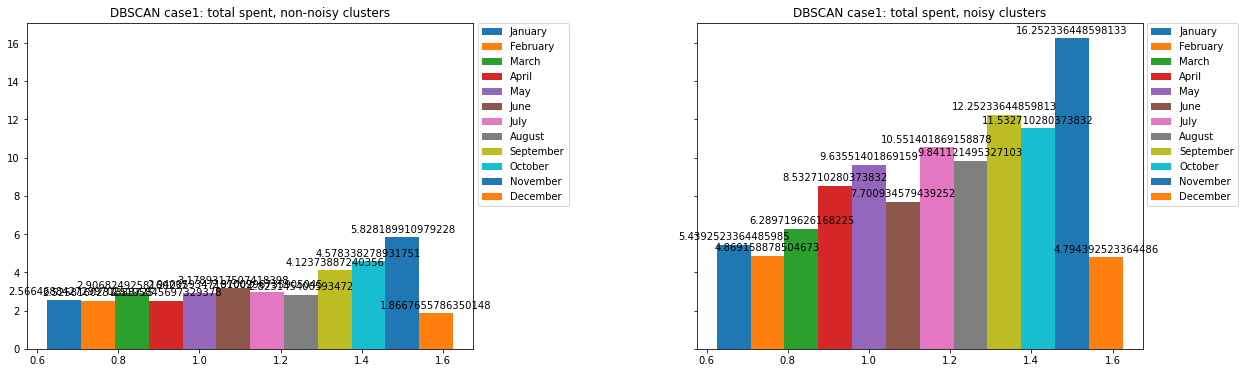

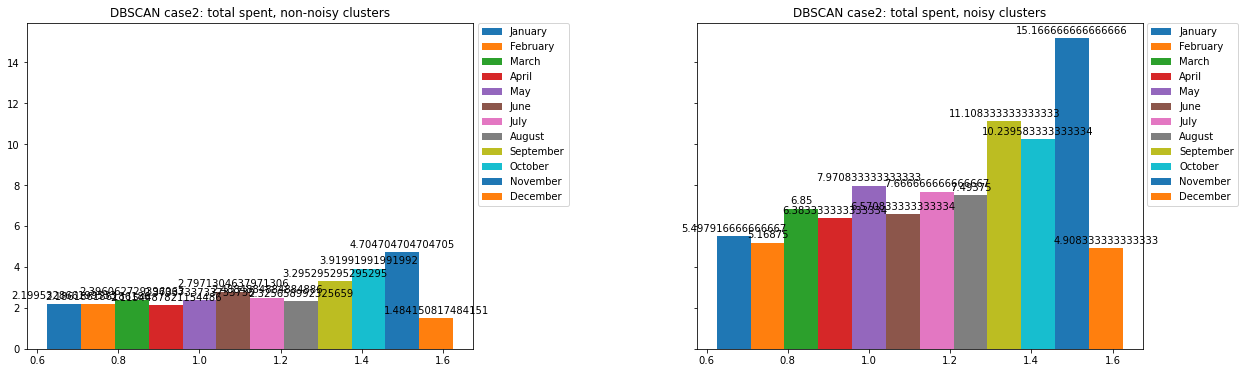

In [68]:
# PLOTS FOR MONTLY TOTAL SPENT
months=[]
for i in range(8,20):
    months.append(cs_cat.columns[i])
    
m_cust= pd.DataFrame(columns=months)
j=0
for column in m_cust:
    m_cust[column] = cs_clusters.Stot.groupby([cs_clusters[column]]).sum()
    j+=1
    
monthly_bar_spent = [[] for _ in range(4)]

for i in range(12):
    monthly_bar_spent[0].append(cs_clusters[cs_clusters.DBS1 == 0][m_cust.columns[i]].mean())
    monthly_bar_spent[1].append(cs_clusters[cs_clusters.DBS1 == -1][m_cust.columns[i]].mean())
    monthly_bar_spent[2].append(cs_clusters[cs_clusters.DBS2 == 0][m_cust.columns[i]].mean())
    monthly_bar_spent[3].append(cs_clusters[cs_clusters.DBS2 == -1][m_cust.columns[i]].mean())

    
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6), sharey=True)
f.subplots_adjust(wspace=0.5)

for j in range(2):
    for i in range(8,20):
        point = (1/len(monthly_bar_spent[j]) * i)
        autolabel(axs[j].bar(point, monthly_bar_spent[j][i-8], 1/len(monthly_bar_spent[j]), label=cs_cat.columns[i]), j)
    axs[j].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title('DBSCAN case' + str(1) + ': total spent, non-noisy clusters')     
    axs[1].set_title('DBSCAN case' + str(1) + ': total spent, noisy clusters')     

    
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6), sharey=True)
f.subplots_adjust(wspace=0.5)

for j in range(2):
    for i in range(8,20):
        point = (1/len(monthly_bar_spent[j+2]) * i)
        autolabel(axs[j].bar(point, monthly_bar_spent[j+2][i-8], 1/len(monthly_bar_spent[j+2]), label=cs_cat.columns[i]), j)
    axs[j].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title('DBSCAN case' + str(2) + ': total spent, non-noisy clusters')     
    axs[1].set_title('DBSCAN case' + str(2) + ': total spent, noisy clusters')     

## DBSCAN conclusions

#### Pros
- Deciding *a priori* the number of clusters is not needed: the algorithm is able to discover them by itself.
- Robust wrt noise: it detects noisy points and assigns them a -1 label (instead in K-Means they're assigned to the closest centroid)
- Is able to find clusters with any shape (not only globular / spherical shape as K-Means does), because there is no notion of *centroids* here.

#### Cons

Density-based clustering methods are somewhat **harder to tune** compared to parametric clustering methods like K-Means. Things like the epsilon parameter for DBSCAN are less intuitive to reason about compared to the number of clusters parameter for K-Means, so it’s more difficult to pick good initial parameter values for these algorithms.

As a matter of fact, we had to do a lot of executions in order to tune parameters in a sufficient good way (see above *Parameter tuning*).

Another limit of DBSCAN algorithm is that it **not able to not recognize different densities**. From the scatter plots above it is easy to see that DBSCAN does not works very well in varying-densities environment.

For this reason we had to distinguish between two different results interpretation.

# Clustering analysis by hierarchical clustering

Hierarchical approaches to clustering are useful when having an nested structure among the cluster is a necessity. The main drawbacks of such approaches are the time and space performances and, for this reasons, they're usually combined with other clustering analysis like k-means.

The hierarchy of clusters can be visualized with a dendogram: a tree structure where the horizontal lines represent the merging of two nodes, or clusters, and the vertical line provides information regarding the distance (or similarity) between said elements. By the end of the agglomerative bottom-up process, the dendrogram ends up displaying the whole merging process leading to a single universal cluster. Every number of clusters can be obtained by cutting the tree at the right level / height.

**About distances**

The first step is to compute the matrix accounting the distances among each of the point in our dataframe. Said computing can be performed by the **scipy** function **pdist** or by specifying the a particulare metric as a parameter of the **AgglomerativeClustering** class of **Sklearn**. 

Both alternatives are able to compute distances with respect to several well-known metrics or even custom ones specifically defined by the user. 
For the sake of this analysis, and due to the rich presence of continuous numerical data, we are going to select the **Euclidean distance** as our metrics of choice.

**About linkage**

The second step is usually to chose a linkage method, that is chosing *how* the computation of the aforementioned distance is going to be performed. Again, the list of methods for linkage contains several choices, mainly leading to:
- Max / Complete-Linkage
- Min / Single-linkage
- Average-linkage
- Ward-linkage

Throughout this notebook we are going to analize and discuss the application of these main methods while highlighting, and assessing, their principal advantages and drawbacks.  

**Optimal value of k in hierarchical clustering**

Hiearchical approaches don't usually provide, at least explicity, an ideal number of clusters. 
Said parameter can be inferred, other than via familiar methods as the elbow and Silhouette plots, by analysing the dendrogram describing our hierarchy.    

The best "cut" for the dendrogram is placed at a height where the line can traverse the maximum distance without intersecting an horizontal line representing a merging point. Said method, however, is not perfect and the selection of an optimal k is often influenced by the characteristics of the dataset or the application of the clustering itself. Also, the **dendrogram** function from **scipy**, thanks to the **color_threshold** parameter, is able to highlight with different colors the links connecting nodes particularly close to each other, hence providing a powerful insight regarding the main clusters whitin the dataset.  

In [69]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [70]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### The Nearest Point Algorithm: single-linkage
For this algorithm, the proximity between two clusters is based on the proximity of the two closest points. 
<br>It tends to perform similarly to DBSCAN. 

While most of the linkage methods tends to prefer clusters of globular shapers, the main advantage of this approach is being able to recognize non-elliptical clusters too.
On the other way, the single-linkage is notoriously sensitive to noise and outliers. 
According to such premises we could expect otherwise unrelated clusters being clumped together by one of these noisy point. 

We proceed by computing the clustering.

In [71]:
# We want to compute the entire tree
model_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single').fit(cs_norm_minmax) 

#### Dendrogram

In [72]:
# We plot the dendrogram
plot_dendrogram(model_single, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)
plt.title('Hierarchical Clustering by Nearest Point Algorithm (single-linkage)')
plt.xlabel('CustomerID or (Cluster Size)')
plt.ylabel('Distance')
plt.show()

AttributeError: 'AgglomerativeClustering' object has no attribute 'distances_'

Here the dendrogram seems to suggest the presence of two main clusters, the first (orange in the graph) containing most of the dataset population and the second made up by mostly unrelated points. This is due to the truncation of the tree due to the truncate_mode parameter of the dendrogram function. Said truncate_mode, set to 'lastp', enables the plot of just the last p non-singleton clusters formed by the alorithm, in this case 30.

### The Farthest Point Algorithm: complete-linkage
It is based on the complete (Max) linkage, measuring the proximity of two clusters by the distance of their fartherst points.

Being more resistant to outliers and noise, the complete-linkage should prove more reliable than the single one.
The complete-linkage is also known for breaking the larger clusters into smaller globular ones. 

Once again we compute the clustering and print the resulting dendrogram.

In [73]:
# We want to compute the entire tree
model_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete').fit(cs_norm_minmax) 

#### Dendrogram

In [74]:
# We plot the dendrogram
plot_dendrogram(model_complete, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)
plt.title('Hierarchical Clustering by Farthest Point Algorithm (complete-linkage)')
plt.xlabel('CustomerID or (Cluster Size)')
plt.ylabel('Distance')
plt.show()

AttributeError: 'AgglomerativeClustering' object has no attribute 'distances_'

Here the dendrogram seems to suggest the presence of three main clusters. A result similar to what suggested by the elbow method utilized within the K-means section.

### The UPGMA Algorithm: average-linkage
It stands as a trade-off between the complete and single linkages. The proximity of two clusters is the average of the pairwise proximity between the points of the two clusters.

Expectations:
- As the complete linkage, it is less susceptible to noise and outliers
- Again, it also tends to prefer globular clusters

In [ ]:
# We want to compute the entire tree
model_average = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average').fit(cs_norm_minmax) 

#### Dendrogram

In [ ]:
# We plot the dendrogram
plot_dendrogram(model_average, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)
plt.title('Hierarchical Clustering by Incremental Algorithm (ward-linkage)')
plt.xlabel('CustomerID or (Cluster Size)')
plt.ylabel('Distance')
plt.show()

### The Incremental Algorithm: ward-linkage
It stands as the hierarchical analogue of K-means and, like the former, it is a centroid based approach with a particular interest in the minimization of the SSE values associated with each cluster.


In [ ]:
 # We want to compute the entire tree
model_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward').fit(cs_norm_minmax)

#### Dendrogram

In [ ]:
# We plot the dendrogram
plot_dendrogram(model_ward, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)
plt.title('Hierarchical Clustering by Incremental Algorithm (ward-linkage)')
plt.xlabel('CustomerID or (Cluster Size)')
plt.ylabel('Distance')
plt.show()